# COVID-19 & Changes in the MiBici Bikesharing System

# Introduction

[MiBici](https://mibici.net/) is Guadalajara's public bike sharing system in the state of Jalisco, Mexico. Created in 2014, the system has over 3,200 bikes and 300 stations available in the municipalities of Guadalajara, Zapopan, and Tlaquepaque. MiBici consists of a line of bikes that are locked into a network of docking stations throughout the municipalities. To use the bikes, one must purchase a subscription. The bikes can be unlocked from one station and returned to any other station in the system. Bikes are available every day of the year from 05:00 AM to 00:59 AM the next day, and are designed to be used for an unlimited number of trips so long as each trip is less than 30 minutes (on Sundays, this is 45 minutes). When bikes are used for periods of more than 30 minutes, additional charges are incurred. The program acts as a complement or extension to other transportation systems in the area [MiBici FAQs](https://mibici.net/es/preguntas-frecuentes/).

As such, the goal of this project is to explore and visualize how cycling behaviors have changed in Guadalajara and its surrounding municipalities due to the COVID-19 pandemic (between January 2017 and December 2022).

# Proposed Research Questions

The following questions are of interest for this analysis:

**1. How has the number of trips taken changed pre and post COVID?**

This question is based on the study by [Padmanabhan et al. (2021)](https://www.sciencedirect.com/science/article/pii/S2590198220301937) who studied the effects of COVID-19 on bike sharing systems in three US cities. The idea here is to compare biking trends to various waves of COVID-19 where cases changed drastically.


**2. Has the trip duration changed over time?**

The MiBici system is described to be used as a commuting option for people. With the lifestyle changes brought about by the COVID-19 pandemic, have people changed how they use the system?


**3. What times of day are most popular to use the MiBici system?**

This question is based on a 2015 [blog post](https://toddwschneider.com/posts/a-tale-of-twenty-two-million-citi-bikes-analyzing-the-nyc-bike-share-system/) by Todd W Schneider who analyzed the Citi Bike system in New York City. They created a plot of the average number of weekday Citi Bike trips by hour of day between Manhattan and the outer boroughs. It illustrates that in the mornings there are more riders entering Manhattan than leaving, and the reverse occurs in the afternoon; illustrating commuter patterns like rush hour (when people are heading to and from work/school).


**4. What are the most popular routes taken and starting stations used?**

Are the popular locations that users visit different from the ones they visited before the start of the pandemic?

# Data Sources

## MiBici

The MiBici [open data](https://www.mibici.net/es/datos-abiertos/) webpage contains over 20 million observations across 14 variables. Each observation represents a bike ride, and each variable contains information about the bike ride. Reverse geocoding was used in Python to obtain the full address, neighborhood, and municipality of each station.

<center><img src='../../MiBici_Data/Tableau_Datasets/Backgrounds/data_analysis_variables.png' width="600"/></center>


<center>MiBici Open Data Variables</center>

## COVID-19

The general directive of epidemiology for the Mexican government maintains a [dashboard](https://datos.covid-19.conacyt.mx/) of COVID-19 data for the country. In this analysis, the _**daily counts of confirmed cases**_ are used for the municipalities of interest.

# Import Libraries

In [2]:
# Web scraping libraries
import requests
import urllib.request
from bs4 import BeautifulSoup


# Downloading, moving and unzipping files
import webbrowser
from time import sleep
import shutil
import os
import glob
from pathlib import Path


# Reverse Geocode
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter


# google directions api
import polyline  # convert polyine into coordinates
import folium    # mapping routes


# DataFrame exploration and manipulation
import pandas as pd
import datetime as dt
import re


# Data Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Show image files
from IPython.display import Image

# Show all columns
pd.set_option('display.max_columns', None)


# Data Cleaning

## Obtain MiBici Data Files

The code for obtaining the MiBici data files from their website is based on the code produced by Fausto De La Rosa Mañón for their analysis on the NYC Citibike dataset. The article for their analysis can be found on [Medium](https://medium.com/@fausto.manon/building-a-citibike-database-with-python-9849a59fb90c)
and the code on [GitHub](https://github.com/fmanon/Citibike_Trip_Data/blob/master/code/01_Create_Database.ipynb).

Request access to the MiBici Open Data webpage. `<Response [200]>` indicates that the request is successful.

In [ ]:
url = 'https://www.mibici.net/es/datos-abiertos/'
response = requests.get(url, headers={"User-Agent": "XY"})
response

Parse the webpage using BeautifulSoup. This is to determine what HTML tag is used to identify the data files. 

In [ ]:
soup = BeautifulSoup(response.text, 'xml')

The .csv files that we want are stored with an `/<a>` tag.

In [ ]:
data_files = soup.find_all('a')

Edit the `data_files` variable to remove the non-data elements.

In [ ]:
data_files = data_files[35:107]

In [ ]:
data_files

Edit the `data_files` variable to get the data file name address.

In [ ]:
def get_file_names(data_list):
    list = []
    for index in range(len(data_list)):
        list.append(data_list[index].attrs.get('href'))
    return list

In [ ]:
data_files = get_file_names(data_files)

In [ ]:
data_files

Retreive all of the csv files from the website by iterating through each list item and leveraging the `webbrowser` library to open each respective download link.

In [ ]:
url2 = 'https://www.mibici.net'
for file in data_files:
    webbrowser.open_new(url2 + file)
    sleep(60)

After downloading all of the respective files, relocate them from the `/Download` folder to the destination folder of the project.

In [ ]:
source = 'C:/Users/Delan/Downloads/'
destination = '../../MiBici_Data/Original_BikeData/'

# Unzip files and clean up data folder
keywords = ['datos_abiertos', 'nomenclatura_2022']

# Move from Download folder to data folder
for item in os.listdir(source):
    for keyword in keywords:
        if keyword in item:
            shutil.move(source + item, destination)

Move the nomenclature file (with station data) to the parent folder.

In [ ]:
source = '../../MiBici_Data/Original_BikeData/'
destination = '../../MiBici_Data/'

# Unzip files and clean up data folder
keywords = ['nomenclatura_2022']

# Move from Download folder to data folder
for item in os.listdir(source):
    for keyword in keywords:
        if keyword in item:
            shutil.move(source + item, destination)

## Fix Column Names

Check the details of the files, see what column headers they all share in common. 
* They share all have the same columns except the birth year of the rider.
* There is an issue with the `ñ` in the word `año` for the birth year variable between some files.

In [2]:
files = glob.glob(r'../../MiBici_Data/Original_BikeData/*.csv')

In [3]:
def get_common_columns(files, **kwargs):
    
    #Get set intersection of column-names of specified CSV files
    common_columns = set(pd.read_csv(files[0], nrows=0, **kwargs, encoding='latin-1').columns)
    
    for f in files[1:]:
        common_columns &= set(pd.read_csv(f, nrows=0, **kwargs, encoding='latin-1').columns)
    return common_columns

In [4]:
get_common_columns(files)

{'Destino_Id',
 'Fin_del_viaje',
 'Genero',
 'Inicio_del_viaje',
 'Origen_Id',
 'Usuario_Id',
 'Viaje_Id'}

Change column names and add additional variables to each file

In [5]:
# function to translate the columns names into English
def fix_colNames(data_frame):
    return data_frame.rename(columns=({'Viaje_Id'          :'Trip_ID',
                                       'Usuario_Id'        :'User_ID',
                                       'Genero'            :'Gender',
                                       'Año_de_nacimiento' :'Birth_Year',
                                       'AÃ±o_de_nacimiento':'Birth_Year',
                                 
                                       'Inicio_del_viaje' :'Start_Time',
                                       'Fin_del_viaje'    :'End_Time',
                                       'Origen_Id'        :'Start_Station_ID',
                                       'Destino_Id'       :'End_Station_ID'}
                             ))

In [6]:
# Function to convert start/end time variables into datetime objects and calculate the trip duration
def Create_DateTime(data_frame, index):
    
    data_frame['Start_Time'] = pd.to_datetime(data_frame['Start_Time'])
    data_frame['End_Time'] = pd.to_datetime(data_frame['End_Time'])
    data_frame['Duration'] = (data_frame['End_Time'] - data_frame['Start_Time']).dt.total_seconds()/60

    return data_frame

In [7]:
# Function to create more start time variables: hour of day, weekday, and month of trip
# 1 = Monday -> 7 = Sunday
def Create_StartVariables(data_frame):
    
    data_frame['Start_Hour']    = data_frame['Start_Time'].apply(lambda x: x.hour).astype('category')
    data_frame['Start_Month']   = data_frame['Start_Time'].apply(lambda x: x.month).astype('category')
    data_frame['Start_Weekday'] = data_frame['Start_Time'].apply(lambda x: x.isoweekday()).astype('category')
    data_frame['Start_Weekday'] = data_frame['Start_Weekday'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday',
                                                                   5:'Friday', 6:'Saturday', 7:'Sunday'})
    return data_frame

In [8]:
# obtain the csv data file names
oldPath = "../../MiBici_Data/Original_BikeData/"
newPath = "../../MiBici_Data/FirstCleaning/"

# keep track of file count
file_index = 1                                 

# collect dataset file names per month into list
temp_file_names = [os.path.basename(x) for x in glob.glob(oldPath+'*.csv')]

# Loop through each file, make changes, save in 'CleanData' folder
for file in temp_file_names:
    
    df = pd.read_csv(os.path.join(oldPath, file), encoding='latin-1')     # read in file as dataframe
    
    df = fix_colNames(df)                  # translate/rename columns
    df = Create_DateTime(df, file_index)   # Clean Start/End time variables. Create trip duration variable
    df = Create_StartVariables(df)         # obtain additional info on start_time: hour, weekday, month
    
    # Make a copy of the new formatted file into the 'CleanDataFolder'
    df.to_csv(newPath + file, index=False)
    
    file_index = file_index + 1  # onto the next file

## Add Location Data

Reverse geolocating is used to obtain more detailed information about the locations of each bike station (e.g., municipality, neighborhood, etc.).

Read in the `nomenclatura` file that contains the name, latitiude, and longitude information for each bike station

In [2]:
all_stations_df = pd.read_csv('../../MiBici_Data/nomenclatura_2022_12.csv', encoding='latin-1')

Take a peek at the dataframe.

In [3]:
all_stations_df.head()

,id,name,obcn,location,latitude,longitude,status
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE


Check for missing data.

In [4]:
all_stations_df.isnull().values.any()

False

Create a new variable that concatenates the latitude and longitude.

In [5]:
all_stations_df['geometry'] = all_stations_df['latitude'].map(str) + ',' + all_stations_df['longitude'].map(str)

In [6]:
all_stations_df.head(10)

,id,name,obcn,location,latitude,longitude,status,geometry
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882"
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366"
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252"
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255"
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863"
5,8,(GDL-006) C. Venustiano Carranza /C. Reforma,GDL-006,POLÍGONO CENTRAL,20.680717,-103.344415,IN_SERVICE,"20.680717,-103.344415"
6,9,(GDL-007) C. Epigmenio Glez./Av. Cristobal C.,GDL-007,POLÍGONO CENTRAL,20.666771,-103.350562,IN_SERVICE,"20.666771,-103.350562"
7,10,(GDL-008) C. J. Angulo / C. González Ortega,GDL-008,POLÍGONO CENTRAL,20.681871,-103.350396,IN_SERVICE,"20.681871,-103.350396"
8,11,(GDL-009) Calz. Federalismo/ C. J. Angulo,GDL-009,POLÍGONO CENTRAL,20.681984,-103.353835,IN_SERVICE,"20.681984,-103.353835"
9,12,(GDL-010) C. Cruz verde / C. Joaquin Angulo,GDL-010,POLÍGONO CENTRAL,20.681852,-103.357338,IN_SERVICE,"20.6818519,-103.3573381"


In [13]:
# strip all whitespace from geometry
all_stations_df['geometry'] = all_stations_df.geometry.apply(lambda x: x.strip())

Reverse geolocate each station

In [14]:
# use the Photon Geocoding service for openstreetmap data
locator = Photon(user_agent="measurements")

# set a timer between address searches so that API doesn't get overwhelmed
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.005)  

In [15]:
# extract the address for each station
all_stations_df['address'] = all_stations_df['geometry'].apply(rgeocode)

In [16]:
# take a ppek at the data
all_stations_df.head()

,id,name,obcn,location,latitude,longitude,status,geometry,address
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Cristóbal Colón, 44180, Calle C..."
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias..."
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ..."
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G..."
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J..."


Check for missing address data.

In [17]:
all_stations_df.address.isnull().values.any()

False

Take a peek at the new address variable

In [18]:
all_stations_df.address[10].raw

{'geometry': {'coordinates': [-103.360048, 20.6810774], 'type': 'Point'},
 'type': 'Feature',
 'properties': {'osm_id': 4316576338,
  'country': 'México',
  'city': 'Guadalajara',
  'countrycode': 'MX',
  'postcode': '44200',
  'locality': 'Santa Tere',
  'type': 'house',
  'osm_type': 'N',
  'osm_key': 'amenity',
  'street': 'Calle Garibaldi',
  'osm_value': 'bicycle_rental',
  'name': 'MiBici',
  'state': 'Jalisco'}}

Extract the neighbourhood and city names for each bike station.

In [19]:
# neighborhood
all_stations_df.address[0].raw.get('properties').get('locality')

'Mexicaltzingo'

In [20]:
# city
all_stations_df['address'][0].raw.get('properties').get('city')

'Guadalajara'

In [21]:
all_stations_df['city']          = all_stations_df['address'].apply(lambda x : x.raw.get('properties').get('city'))
all_stations_df['neighbourhood'] = all_stations_df['address'].apply(lambda x : x.raw.get('properties').get('locality'))

In [22]:
all_stations_df.head(5)

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Cristóbal Colón, 44180, Calle C...",Guadalajara,Mexicaltzingo
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias...",Guadalajara,Americana
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ...",Guadalajara,Obrera
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G...",Guadalajara,Mezquitán Country
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J...",Guadalajara,La Perla


Check unique values for city & neighborhoods

In [23]:
set(all_stations_df.city)

{'Guadalajara',
 'Guadalajara, Jalisco',
 None,
 'San Pedro Tlaquepaque',
 'Tlaquepaque',
 'Zapopan'}

In [24]:
set(all_stations_df.neighbourhood)

{'Americana',
 'Analco',
 'Arcos Vallarta',
 'Barranquitas',
 'Barrio de Mezquitán',
 'Belenes Norte',
 'Camino Real',
 'Capilla de Jesús',
 'Centro Barranquitas',
 'Chapalita',
 'Chapalita Oriente',
 'Chapultepec Country',
 'Circunvalación',
 'Circunvalación Guevara',
 'Ciudad de los Niños',
 'Ciudad del Sol',
 'Colinas de la Normal',
 'Colonia del Periodista',
 'Country Plaza',
 'Don Bosco Vallarta',
 'El Capullo',
 'El Vigía',
 'Guadalajara Centro',
 'Guadalupe',
 'Hacendarios',
 'Ibarra y Molodom',
 'Independencia Oriente',
 'Independencia Sur',
 'Industrial Los Belenes',
 'Italia',
 'Jacarandas',
 'Jardines de Los Arcos 1a Sección',
 'Jardines de San Ignacio',
 'Jardines del Bosque',
 'Jardines del Bosque Norte',
 'Jardines del Country',
 'Juan Diego',
 'La Normal',
 'La Perla',
 'Ladrón de Guevara',
 'Las Flores',
 'Las Nueve Esquinas',
 'Laureles',
 'Loma Blanca',
 'Los Maestros',
 'Mexicaltzingo',
 'Mezquitán',
 'Mezquitán Country',
 'Miraflores',
 'Moderna',
 None,
 'Obrera',


* Truncate city name from `San Pedro Tlaquepaque` to `Tlaquepaque`
* Truncate city name from `Guadalajara, Jalisco` to `Guadalajara`

In [26]:
# Only one item is listed as 'San Pedro Tlaquepaque' & 'Guadalajara, Jalisco'
print(sum(all_stations_df['city'] == 'San Pedro Tlaquepaque'))
print(sum(all_stations_df['city'] == 'Guadalajara, Jalisco'))

1
1


In [27]:
all_stations_df.loc[all_stations_df['city'] == 'San Pedro Tlaquepaque', 'city'] = 'Tlaquepaque'
all_stations_df.loc[all_stations_df['city'] == 'Guadalajara, Jalisco', 'city'] = 'Guadalajara'

Check for missing data:
* Rows with missing neighborhood data are manually corrected.

In [28]:
all_stations_df.isnull().values.any()

True

In [29]:
all_stations_df.isnull().sum()

id                0
name              0
obcn              0
location          0
latitude          0
longitude         0
status            0
geometry          0
address           0
city              1
neighbourhood    29
dtype: int64

Remove text in parenthesis in name column

In [30]:
# take a peek at data
all_stations_df.head(5)

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
0,2,(GDL-001) C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Cristóbal Colón, 44180, Calle C...",Guadalajara,Mexicaltzingo
1,3,(GDL-002) C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias...",Guadalajara,Americana
2,4,(GDL-003) C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ...",Guadalajara,Obrera
3,5,(GDL-004) C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G...",Guadalajara,Mezquitán Country
4,6,(GDL-005) C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J...",Guadalajara,La Perla


In [31]:
# remove parenthesis
all_stations_df['name'] = all_stations_df['name'].str.split(')').str[1]

In [32]:
all_stations_df.head()

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
0,2,C. Epigmenio Glez./ Av. 16 de Sept.,GDL-001,POLÍGONO CENTRAL,20.666378,-103.348820,IN_SERVICE,"20.666378,-103.34882","(MiBici, Calle Cristóbal Colón, 44180, Calle C...",Guadalajara,Mexicaltzingo
1,3,C. Colonias / Av. Niños héroes,GDL-002,POLÍGONO CENTRAL,20.667228,-103.366000,IN_SERVICE,"20.667228,-103.366","(MiBici, Calle Colonias, 44140, Calle Colonias...",Guadalajara,Americana
2,4,C. Vidrio / Av. Chapultepec,GDL-003,POLÍGONO CENTRAL,20.667690,-103.368252,IN_SERVICE,"20.66769,-103.368252","(Ui Internacional, 1984, Calle Vidrio, 44150, ...",Guadalajara,Obrera
3,5,C. Ghilardi /C. Miraflores,GDL-004,POLÍGONO CENTRAL,20.691750,-103.362550,IN_SERVICE,"20.69175,-103.36255","(918, Calle Ghilardi, 44610, Calle Ghilardi, G...",Guadalajara,Mezquitán Country
4,6,C. San Diego /Calzada Independencia,GDL-005,POLÍGONO CENTRAL,20.681151,-103.338863,IN_SERVICE,"20.681151,-103.338863","(Calle Esteban Alatorre, 44360, Guadalajara, J...",Guadalajara,La Perla


Save the modified data frame to the project folder

In [33]:
# all_stations_df.to_csv('../../MiBici_Data/nomenclatura_2022_12_updated.csv', index=False, encoding = 'utf-8')

## Combine Station/Trip Datasets

Read in new bike station dataset

In [24]:
# import edited station location dataset
all_stations_new_df = pd.read_csv('../../MiBici_Data/nomenclatura_2022_12_updated.csv', encoding='utf-8')

In [25]:
# Check to make sure formatting is OK
all_stations_new_df.tail(5)

,id,name,obcn,location,latitude,longitude,status,geometry,address,city,neighbourhood
307,323,C. Palavicini / Av. Circunvalación,GDL-213,POLÍGONO CENTRAL,20.704670,-103.345589,IN_SERVICE,"20.70467,-103.345589","Calle Félix Palavicini, 44220, Guadalajara, Ja...",Guadalajara,Ibarra y Molodom
308,324,De los científicos/ J. J. Tablada,GDL-221,POLÍGONO CENTRAL,20.700192,-103.345961,IN_SERVICE,"20.700192,-103.345961","823, Avenida de los Científicos, 44266, Avenid...",Guadalajara,Miraflores
309,325,C. Luis G. Cuevas /Av. Revolución,GDL-226,TLQ-CORREDORATLAS,20.652408,-103.312902,IN_SERVICE,"20.652408,-103.312902","2126, Avenida Revolución, 44410, Avenida Revol...",Guadalajara,Sutaj
310,326,C. D. Rivera / C. Filósofos,GDL-219,POLÍGONO CENTRAL,20.698197,-103.342554,IN_SERVICE,"20.698197,-103.342554","Calle Paseo de los Filósofos, Calle Paseo de l...",Guadalajara,Colinas de la Normal
311,327,C. Artistas / C. Carlos Pereira,GDL-227,POLÍGONO CENTRAL,20.695636,-103.339378,IN_SERVICE,"20.695636,-103.339378","402, Calle Carlos Pereira, 44290, Calle Carlos...",Guadalajara,Barranquitas


Loop through each station type (start/end) and merge location data to full dataset

In [26]:
def CombineLocation(full_df, location_df):
    
    # Set indices of both dataframes for start Locations
    full_df.set_index('Start_Station_ID', drop=False, inplace=True) # Set full dataset index to start index
    location_df.set_index('id', drop=False, inplace=True)           # Set location dataset index to 'id' index

    # Merge location to full dataset
    full_df = pd.merge(full_df, location_df.drop(['id', 'obcn', 'location'], axis=1), left_index=True, right_index=True, how='left')

    # Rename new columns for start locations 
    full_df.rename(columns=({'name'          : 'Start_Name',
                             'latitude'      : 'Start_Latitude',  
                             'longitude'     : 'Start_Longitude',
                             'status'        : 'Start_Status',
                             'geometry'      : 'Start_Geometry',
                             'address'       : 'Start_Address',
                             'city'          : 'Start_City',
                             'neighbourhood' : 'Start_Neighborhood'}
                            ), inplace=True)
    
    # Set indices of both dataframes for start Locations
    full_df.set_index('End_Station_ID', drop=False, inplace=True) # Set full dataset index to start index

    # Merge location to full dataset
    full_df = pd.merge(full_df, location_df.drop(['id', 'obcn', 'location'], axis=1), left_index=True, right_index=True, how='left')

    # Rename new columns for start locations 
    full_df.rename(columns=({'name'          : 'End_Name',
                             'latitude'      : 'End_Latitude',  
                             'longitude'     : 'End_Longitude',
                             'status'        : 'End_Status',
                             'geometry'      : 'End_Geometry',
                             'address'       : 'End_Address',
                             'city'          : 'End_City',
                             'neighbourhood' : 'End_Neighborhood'}
                            ), inplace=True)
    return full_df
    

In [27]:
# obtain the csv data file names
oldPath = "../../MiBici_Data/FirstCleaning/"
newPath = "../../MiBici_Data/SecondCleaning/"
files = [os.path.basename(x) for x in glob.glob('../../MiBici_Data/FirstCleaning/*.csv')]

# Loop through each file, make changes, save in 'SecondCleaning' folder
for file in files:
    
    df = pd.read_csv(os.path.join(oldPath, file), encoding='utf-8')           # read in file as dataframe
    df = CombineLocation(df, all_stations_new_df)                             # add bike station data
    df.iloc[:, 1:].to_csv(newPath + file, index=False, encoding = 'utf-8')    # Make a copy of the new formatted file into the 'SecondCleaning' without extrax index column

## Missing Data

Upload data and separate into data frames by year

In [14]:
# obtain the csv data file names
path = "../../MiBici_Data/SecondCleaning/"
files = [file for file in os.listdir(path) if file.endswith(".csv")]

In [15]:
# Loop through each file, check what year its from, save in appropriate dataframe
MiBici2017 = pd.DataFrame()
MiBici2018 = pd.DataFrame()
MiBici2019 = pd.DataFrame()
MiBici2020 = pd.DataFrame()
MiBici2021 = pd.DataFrame()
MiBici2022 = pd.DataFrame()

for file in files:
    if file[15:19] == '2017':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2017 = pd.concat([MiBici2017, df_temp], axis=0)
        
    elif file[15:19] == '2018':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2018 = pd.concat([MiBici2018, df_temp], axis=0)
        
    elif file[15:19] == '2019':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2019 = pd.concat([MiBici2019, df_temp], axis=0)
        
    elif file[15:19] == '2020':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2020 = pd.concat([MiBici2020, df_temp], axis=0)
        
    elif file[15:19] == '2021':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2021 = pd.concat([MiBici2021, df_temp], axis=0)
    
    elif file[15:19] == '2022':
        df_temp = pd.read_csv(os.path.join(path, file), encoding='utf-8')
        MiBici2022 = pd.concat([MiBici2022, df_temp], axis=0)

Define variables for the 6 datasets to make calculations easier

In [16]:
years_df = [MiBici2017, MiBici2018, MiBici2019, MiBici2020, MiBici2021, MiBici2022]
years = ['2017', '2018', '2019', '2020', '2021', '2022']
weekday_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Check for missing data
* Rides with missing Gender & Birth Year data will not be deleted
* Rows with missing location-related data, are not missing all the same data

In [32]:
pd.concat([MiBici2017.isna().sum(),
           MiBici2018.isna().sum(),
           MiBici2019.isna().sum(),
           MiBici2020.isna().sum(),
           MiBici2021.isna().sum(),
           MiBici2022.isna().sum()], axis=1, keys=years)

,2017,2018,2019,2020,2021,2022
User_ID,0,0,0,0,0,0
Gender,0,0,6415,3349,4832,18154
Birth_Year,12752,11621,11522,3447,4332,15862
Start_Time,0,0,0,0,0,0
End_Time,0,0,0,0,0,0
Start_Station_ID,0,0,0,0,0,0
End_Station_ID,0,0,0,0,0,0
Duration,0,0,0,0,0,0
Start_Hour,0,0,0,0,0,0
Start_Month,0,0,0,0,0,0


Further investigate rides with missing location-related data
* All rows missing station data are associated with the same station (ID = 124). 
* Station ID = 124 is not in the station dataset. It may be a station that was decomissioned. A such, these trips will not be deleted from the dataset.

Take a peek at rows with missing data

In [18]:
MiBici2019[MiBici2019['Start_Name'].isna()]

,User_ID,Gender,Birth_Year,Start_Time,End_Time,Start_Station_ID,End_Station_ID,Duration,Start_Hour,Start_Month,Start_Weekday,Start_Name,Start_Latitude,Start_Longitude,Start_Status,Start_Geometry,Start_Address,Start_City,Start_Neighborhood,End_Name,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood
46254,32401,F,1991.0,2019-01-26 16:46:09,2019-01-26 16:54:42,124,26,8.550000,16,1,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Av. Federalismo / C. Juan Manuel,20.678777,-103.354035,IN_SERVICE,"20.678777,-103.354035","MiBici, Federalismo Sur 47, 44100, Federalismo...",Guadalajara,Barrio de Mezquitán
74565,310153,M,1991.0,2019-01-28 15:31:24,2019-01-28 15:41:32,124,36,10.133333,15,1,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C. Morelos / C. Donato Guerra,20.676461,-103.350244,IN_SERVICE,"20.676461,-103.350244","MiBici, Morelos, 44100, Morelos, Guadalajara, ...",Guadalajara,Guadalajara Centro
79536,477103,F,1998.0,2019-01-26 12:31:53,2019-01-26 12:40:57,124,38,9.066667,12,1,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C. Marcos Castellanos / C. Morelos,20.676078,-103.356458,IN_SERVICE,"20.676078,-103.356458","MiBici, Pedro Moreno, 44100, Pedro Moreno, Gua...",Guadalajara,Capilla de Jesús
150285,226501,M,1993.0,2019-01-26 14:06:09,2019-01-26 14:20:14,124,61,14.083333,14,1,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C. Miguel Blanco / C. Penitenciaria,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana
150286,330512,F,1991.0,2019-01-26 14:06:50,2019-01-26 14:20:06,124,61,13.266667,14,1,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C. Miguel Blanco / C. Penitenciaria,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana
150287,254240,F,1983.0,2019-01-26 14:15:43,2019-01-26 14:20:33,124,61,4.833333,14,1,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C. Miguel Blanco / C. Penitenciaria,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana
199205,307125,M,1988.0,2019-01-22 11:15:24,2019-01-22 11:22:22,124,80,6.966667,11,1,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C. Comercio / C. La Paz,20.667946,-103.346775,IN_SERVICE,"20.667946,-103.346775","MiBici, Calle Comercio, 44180, Calle Comercio,...",Guadalajara,Las Nueve Esquinas
222565,471777,M,1972.0,2019-01-21 14:05:23,2019-01-21 14:05:39,124,124,0.266667,14,1,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222566,307675,F,1993.0,2019-01-23 19:38:09,2019-01-23 19:38:20,124,124,0.183333,19,1,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222567,307675,F,1993.0,2019-01-23 19:38:33,2019-01-23 19:38:41,124,124,0.133333,19,1,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
MiBici2017[MiBici2017['End_Name'].isna()]

,User_ID,Gender,Birth_Year,Start_Time,End_Time,Start_Station_ID,End_Station_ID,Duration,Start_Hour,Start_Month,Start_Weekday,Start_Name,Start_Latitude,Start_Longitude,Start_Status,Start_Geometry,Start_Address,Start_City,Start_Neighborhood,End_Name,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood
150856,212457,M,1970.0,2017-09-20 17:40:56,2017-09-20 18:09:41,11,124,28.750000,17,9,Wednesday,Calz. Federalismo / C. J. Angulo,20.681984,-103.353835,IN_SERVICE,"20.681984,-103.353835","Calzada Federalismo, 44200, Guadalajara, Jalis...",Guadalajara,Capilla de Jesús,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150857,173071,M,1989.0,2017-09-21 17:07:24,2017-09-21 17:22:32,18,124,15.133333,17,9,Thursday,C. Bernardo de Balbuena / C J. Angulo,20.682007,-103.372642,IN_SERVICE,"20.682007,-103.372642","Mibici, Calle Bernardo de Balbuena, 44600, Cal...",Guadalajara,Ladrón de Guevara,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150858,212135,F,1989.0,2017-09-22 11:58:06,2017-09-22 12:08:22,32,124,10.266667,11,9,Friday,C. Pedro Moreno / C. Progreso,20.675461,-103.367501,IN_SERVICE,"20.675461,-103.367501","Mibici, Calle Pedro Moreno, 44100, Calle Pedro...",Guadalajara,Americana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150859,201341,F,1997.0,2017-09-22 13:18:27,2017-09-22 13:25:49,58,124,7.366667,13,9,Friday,Av. 16 de Sept. / C. Miguel Blanco,20.671971,-103.347422,IN_SERVICE,"20.671971,-103.347422","Calle Ferrocarril, Paseo Fray Antonio Alcalde,...",Guadalajara,Las Nueve Esquinas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150860,102377,M,1991.0,2017-09-19 19:04:44,2017-09-19 19:08:02,75,124,3.300000,19,9,Tuesday,Av. La Paz / Av. Federalismo,20.669955,-103.355032,IN_SERVICE,"20.669955,-103.355032","MiBici, Ciclovía La Paz, 44140, Ciclovía La Pa...",Guadalajara,Americana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150861,205050,F,1985.0,2017-09-15 18:58:03,2017-09-15 18:59:10,124,124,1.116667,18,9,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150862,252145,M,1995.0,2017-09-16 08:59:20,2017-09-16 08:59:47,124,124,0.450000,8,9,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150863,253011,M,1966.0,2017-09-18 09:28:00,2017-09-18 09:28:29,124,124,0.483333,9,9,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150864,253011,M,1966.0,2017-09-18 09:28:36,2017-09-18 09:29:04,124,124,0.466667,9,9,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150865,253011,M,1966.0,2017-09-18 09:30:04,2017-09-18 09:30:39,124,124,0.583333,9,9,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Determine which station(s) have missing data

In [55]:
missing_station_list = []

# loop through each annual dataframe to find the station IDs associated with missing Start/End Names
# combine into one list
for i in range(4):
    missing_station_list.extend(years_df[i]['Start_Station_ID'][years_df[i]['Start_Name'].isna()])
    missing_station_list.extend(years_df[i]['End_Station_ID'][years_df[i]['End_Name'].isna()])
                                 

In [57]:
# Group station IDs into a set and check the number of unique sets 
# if len = 1, then all the station IDs are the same.
len(set(missing_station_list))

1

In [58]:
# Station ID
missing_station_list[0]

124

## Clean Trip Duration

Summary Statistics
* Each year has trip durations over 100 hrs long
* These are likely not true trips (stolen bike, uncorrectly parked, etc.)

In [33]:
pd.concat([MiBici2017.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2018.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2019.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2020.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2021.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2022.Duration.describe().apply(lambda x: '%.2f' % x)
          ], axis=1)

,Duration,Duration,Duration,Duration,Duration,Duration
count,2516534.00,3403485.00,4636652.00,2866072.00,3184410.00,4202942.00
mean,38.57,11.45,11.53,11.33,11.02,10.77
std,1891.91,109.93,98.86,27.37,26.87,8.97
min,0.00,0.00,0.02,0.00,0.00,0.00
25%,5.83,5.82,5.85,5.82,5.70,5.57
50%,9.42,9.43,9.55,9.63,9.48,9.30
75%,14.63,14.60,14.80,14.87,14.72,14.55
max,629228.77,125404.75,118583.15,24783.35,28150.77,2754.52


Check the histograms of the trip duration column

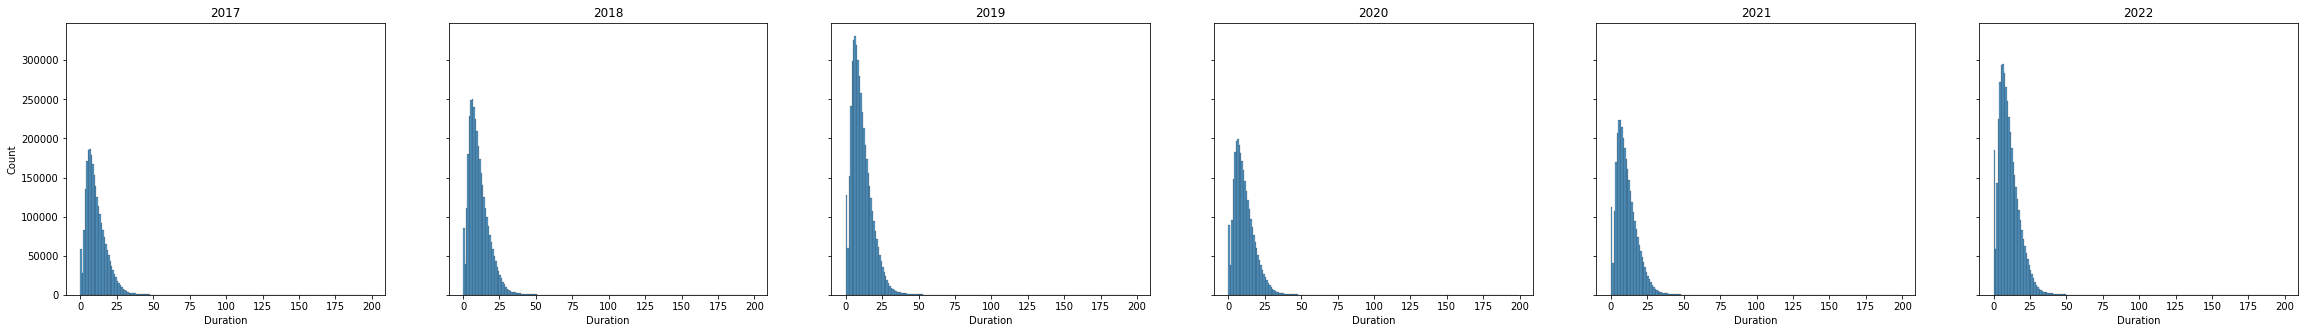

In [34]:
# Loop through each dataset and create its plot
fig, axs = plt.subplots(ncols=6, figsize=(40, 5), sharey=True)
for i in range(len(years)):
    sns.histplot(years_df[i]['Duration'], bins=range(0, 200, 1),  ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

Check the quantiles of the trip duration column

In [35]:
# Calculate the trip duration per year at each quantile
quantiles = [.99, .9975, .998, .9985, .999]

pd.DataFrame([[round(years_df[i].Duration.quantile(quantiles[n]), 4) for i in range(len(years))] \
              for n in range(len(quantiles))],
             columns=years, index = quantiles)

,2017,2018,2019,2020,2021,2022
0.9900,34.8167,33.7833,33.8167,33.0333,32.6152,32.2333
0.9975,78.1222,54.4333,51.5833,47.5333,43.9833,43.1941
0.9980,100.6634,62.5500,58.4000,51.9476,46.4667,45.3667
0.9985,147.5734,79.1462,71.9500,59.6316,50.4231,48.9098
0.9990,266.6989,111.7919,106.4283,77.7667,57.6167,55.3000


Check distribution for rides <= 3 hours (180 minutes)

In [36]:
pd.concat([i.Duration[i.Duration <= 180].describe().apply(lambda x: '%.2f' % x) for i in years_df], axis=1)

,Duration,Duration,Duration,Duration,Duration,Duration
count,2513263.00,3401387.00,4633600.00,2864870.00,3183983.00,4202551.00
mean,11.03,11.00,11.07,11.07,10.91,10.73
std,8.00,7.75,7.65,7.55,7.36,7.34
min,0.00,0.00,0.02,0.00,0.00,0.00
25%,5.82,5.82,5.85,5.82,5.70,5.57
50%,9.40,9.43,9.55,9.63,9.47,9.30
75%,14.62,14.58,14.78,14.85,14.72,14.55
max,179.95,179.95,179.93,179.97,179.87,179.97


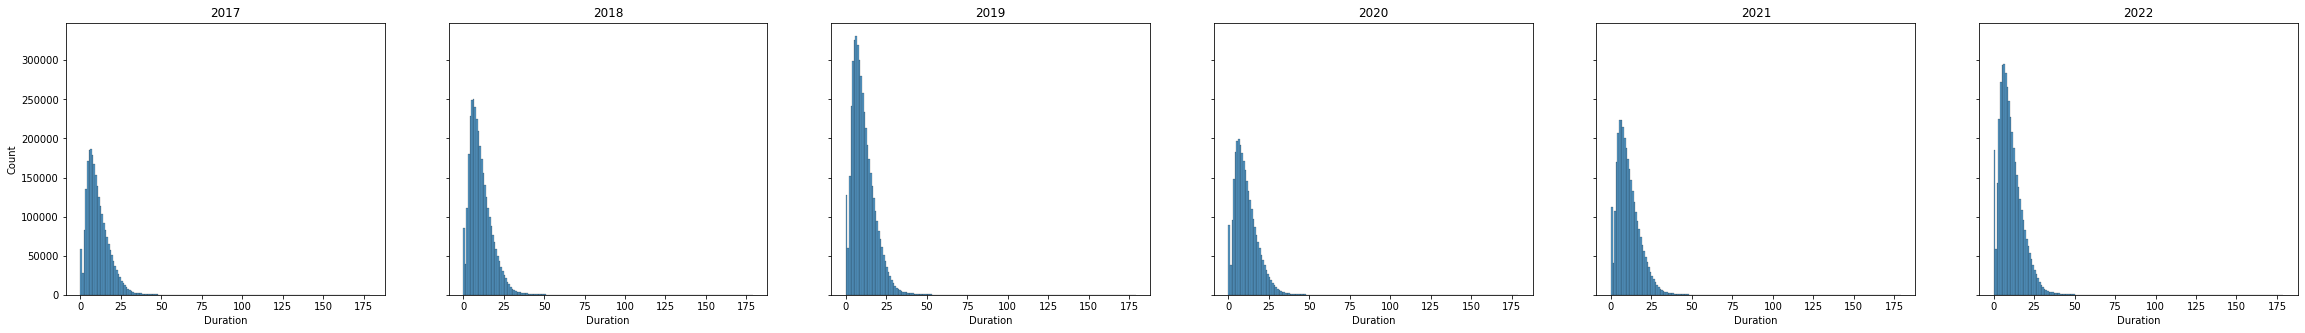

In [37]:
# Loop through each dataset and create its plot
fig, axs = plt.subplots(ncols=6, figsize=(40, 5), sharey=True)
for i in range(len(years)):
    sns.histplot(years_df[i].Duration[years_df[i].Duration <= 180], bins=range(0, 180, 1),  ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

Remove the trips that have a trip duration longer than 3 hours (180 minutes), with the assumption that the bike was improperly checked in, stolen, lost, etc.

In [38]:
MiBici2017 = MiBici2017[MiBici2017.Duration <= 180]
MiBici2018 = MiBici2018[MiBici2018.Duration <= 180]
MiBici2019 = MiBici2019[MiBici2019.Duration <= 180]
MiBici2020 = MiBici2020[MiBici2020.Duration <= 180]
MiBici2021 = MiBici2021[MiBici2021.Duration <= 180]
MiBici2022 = MiBici2022[MiBici2022.Duration <= 180]

Remove trips with a duration less than 1.5 minutes. People may have either mistakenly rented bikes, user error in the checkout process, or the user was simply testing the bike.

In [39]:
MiBici2017 = MiBici2017[MiBici2017.Duration >= 1.5]
MiBici2018 = MiBici2018[MiBici2018.Duration >= 1.5]
MiBici2019 = MiBici2019[MiBici2019.Duration >= 1.5]
MiBici2020 = MiBici2020[MiBici2020.Duration >= 1.5]
MiBici2021 = MiBici2021[MiBici2021.Duration >= 1.5]
MiBici2022 = MiBici2022[MiBici2022.Duration >= 1.5]

New Summary Statistics
* trip duration doesn't change much over time

In [40]:
pd.concat([MiBici2017.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2018.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2019.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2020.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2021.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2022.Duration.describe().apply(lambda x: '%.2f' % x)
          ], axis=1)

,Duration,Duration,Duration,Duration,Duration,Duration
count,2447401.00,3304562.00,4486450.00,2763470.00,3059070.00,3997634.00
mean,11.32,11.30,11.42,11.45,11.34,11.26
std,7.91,7.64,7.53,7.41,7.19,7.14
min,1.50,1.50,1.50,1.50,1.50,1.50
25%,6.08,6.12,6.18,6.20,6.12,6.08
50%,9.62,9.67,9.82,9.93,9.82,9.72
75%,14.80,14.78,15.02,15.10,14.98,14.90
max,179.95,179.95,179.93,179.97,179.87,179.97


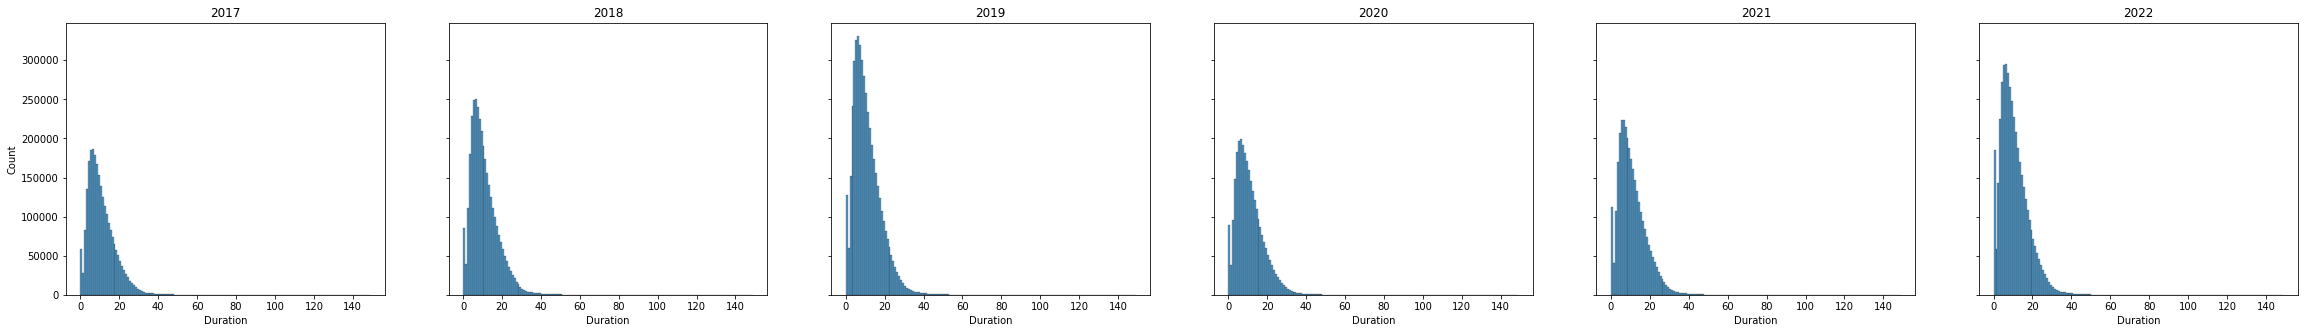

In [41]:
# Loop through each dataset and create its plot
fig, axs = plt.subplots(ncols=6, figsize=(40, 5), sharey=True)
for i in range(len(years)):
    sns.histplot(years_df[i]['Duration'], bins=range(0,150,1), ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

# Explore Data

## Trip Counts

The number of trips taken per year is calculated. One can see that the system experiences growth in ridership annually until the pandemic hits. Even by the end of 2022, the system as not quite returned to pre-pandemic levels.

In [42]:
tripCount_df = pd.DataFrame([len(MiBici2017),
                             len(MiBici2018),
                             len(MiBici2019),
                             len(MiBici2020),
                             len(MiBici2021),
                             len(MiBici2022)],
                            columns=['Count'],
           index=years)
tripCount_df

,Count
2017,2447401
2018,3304562
2019,4486450
2020,2763470
2021,3059070
2022,3997634


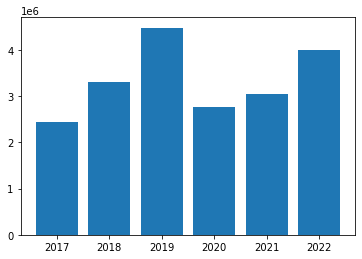

In [43]:
plt.bar(tripCount_df.index, tripCount_df.Count)
plt.show()

Annual number of trips by municipality
* Guadalajara has a larger number of trips per year comparatively. This makes sense since it is the largest city in the state.
* Ridership in Zapopan returned to pre-pandemic levels in 2021 and exceeded 2019 counts in 2022.
* Tlaquepaque takes longer to reach it's pre-pandemic levels. By the end of 2022, it's still not quite there.

In [44]:
pd.DataFrame([years_df[i].groupby(["Start_City"]).size().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

Start_City,Guadalajara,Tlaquepaque,Zapopan
2017,2367409,45366,103741
2018,3204997,62697,135791
2019,4304221,76029,256386
2020,2642093,49104,174869
2021,2885425,51300,247685
2022,3788902,60543,353497


<AxesSubplot: >

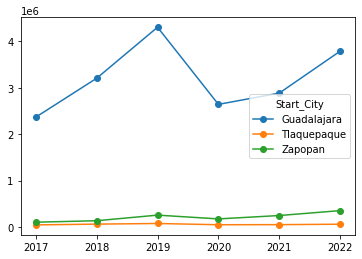

In [65]:
pd.DataFrame([years_df[i].groupby(["Start_City"]).size().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years).astype(int).plot(linestyle='-', marker='o')

<AxesSubplot: >

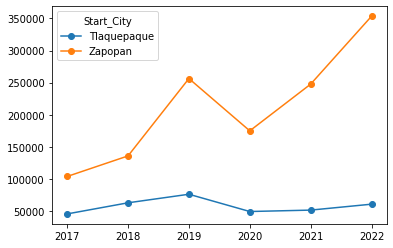

In [64]:
pd.DataFrame([years_df[i].groupby(["Start_City"]).size().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years).astype(int).drop('Guadalajara', axis=1).plot(linestyle='-', marker='o')

## Gender

Men use the bike system far more than women do. However, the system sees growth in users of both genders, both before and after the drop in ridership due to the pandemic.

In [46]:
# Statistics
pd.DataFrame([years_df[i].Gender.astype('category').describe(include='category') \
              for i in range(len(years)) 
             ], index=years)

,count,unique,top,freq
2017,2516534,2,M,1899924
2018,3403485,2,M,2543132
2019,4630237,2,M,3439925
2020,2862723,2,M,2114951
2021,3179578,2,M,2315220
2022,4184788,2,M,3050049


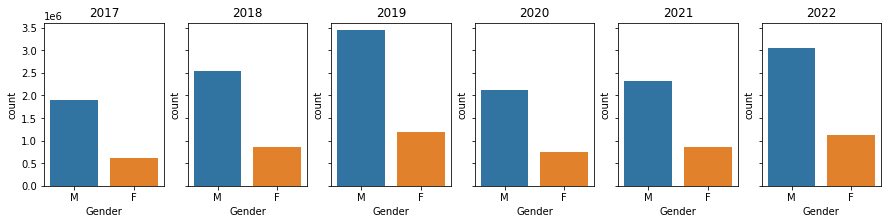

In [47]:
# Loop through each dataset and create its plot
fig, axs = plt.subplots(ncols=6, figsize=(15, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x = 'Gender', data = years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

## Birth Year

Statistics

In [48]:
pd.DataFrame([years_df[i].Birth_Year.describe().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,mean,std,min,25%,50%,75%,max
2017,2503782,1985,10,1917,1981,1988,1992,2001
2018,3391864,1986,10,1917,1982,1989,1993,2002
2019,4625130,1987,10,1917,1982,1990,1994,2003
2020,2862625,1987,10,1917,1982,1990,1994,2003
2021,3180078,1987,25,1,1982,1990,1995,2021
2022,4187080,1989,20,1,1984,1991,1996,2022


**All datasets:**
* assume no one under 70 years is riding  (replace with NaN

**2021 & 2022 datasets:**
* Replace Birth year > 2005 & 2006 with NaN (like all other years, youngest rides are 16 yrs old because this is the youngest age users can get a subscription [MiBici](https://www.mibici.net/es/preguntas-frecuentes/)

In [49]:
MiBici2017['Birth_Year'] = MiBici2017.Birth_Year.mask(MiBici2017.Birth_Year < 1947)
MiBici2018['Birth_Year'] = MiBici2018.Birth_Year.mask(MiBici2018.Birth_Year < 1948)
MiBici2019['Birth_Year'] = MiBici2019.Birth_Year.mask(MiBici2019.Birth_Year < 1949)
MiBici2020['Birth_Year'] = MiBici2020.Birth_Year.mask(MiBici2020.Birth_Year < 1950)

MiBici2021['Birth_Year'] = MiBici2021.Birth_Year.mask(MiBici2021.Birth_Year > 2005)
MiBici2021['Birth_Year'] = MiBici2021.Birth_Year.mask(MiBici2021.Birth_Year < 1951)

MiBici2022['Birth_Year'] = MiBici2022.Birth_Year.mask(MiBici2022.Birth_Year > 2006)
MiBici2022['Birth_Year'] = MiBici2022.Birth_Year.mask(MiBici2022.Birth_Year < 1952)

Check stats again

In [50]:
years_df = [MiBici2017, MiBici2018, MiBici2019, MiBici2020, MiBici2021, MiBici2022]

pd.DataFrame([years_df[i].Birth_Year.describe().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,mean,std,min,25%,50%,75%,max
2017,2433710,1985,10,1947,1981,1988,1992,2001
2018,3290736,1987,10,1948,1982,1989,1993,2002
2019,4467028,1987,10,1949,1982,1990,1994,2003
2020,2749483,1987,10,1950,1982,1990,1994,2003
2021,3044068,1987,10,1951,1982,1990,1995,2005
2022,3968280,1989,10,1952,1984,1991,1996,2006


## Age

Calculate age from birth year

In [51]:
# Subtract the birth year from the year of the dataframe (e.g., 2017 - 1985)
for i in range(len(years)):
    years_df[i]['Age'] = int(years[i]) - years_df[i].Birth_Year

In [52]:
# Move age column next to birth year column
for yr in years_df:
    column_to_move = yr.pop("Age")
    yr.insert(4, "Age", column_to_move)

Age stats:
* The most common rider age (mode) was 27, 26, 25, 26, 27, 26 years respectively
* The mean ages are betwwn 32-34 years
* Median age is between 29-31 years

In [53]:
# stats as integers
pd.DataFrame([years_df[i].Age.describe().apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,mean,std,min,25%,50%,75%,max
2017,2433710,32,10,16,25,29,36,70
2018,3290736,31,10,16,25,29,36,70
2019,4467028,32,10,16,25,29,37,70
2020,2749483,33,10,17,26,30,38,70
2021,3044068,34,10,16,26,31,39,70
2022,3968280,33,10,16,26,31,38,70


In [54]:
# stats as categories
pd.DataFrame([years_df[i].Age.astype('category').describe(include='category').apply(lambda x: '%.0f' % x) \
              for i in range(len(years)) 
             ], index=years)

,count,unique,top,freq
2017,2433710,55,27,167522
2018,3290736,55,26,214307
2019,4467028,55,25,271261
2020,2749483,54,26,157368
2021,3044068,55,27,170076
2022,3968280,55,26,235030


Categorize ages into bins: "<20", "20s", "30s", "40s", "50s", "60+"

In [55]:
for i in range(len(years)):
    years_df[i]['Age_category'] = pd.cut(years_df[i]['Age'], 
                                         bins = [0,20,30,40,50,60,200], 
                                         labels = ["<20", "20s", "30s", "40s", "50s", "60s"], 
                                         include_lowest=True)

Statistics & Plot

In [56]:
pd.DataFrame([years_df[i].Age_category.describe() \
              for i in range(len(years)) 
             ], index=years)

,count,unique,top,freq
2017,2433710,6,20s,1286651
2018,3290736,6,20s,1748189
2019,4467028,6,20s,2308731
2020,2749483,6,20s,1301693
2021,3044068,6,20s,1380566
2022,3968280,6,20s,1823553


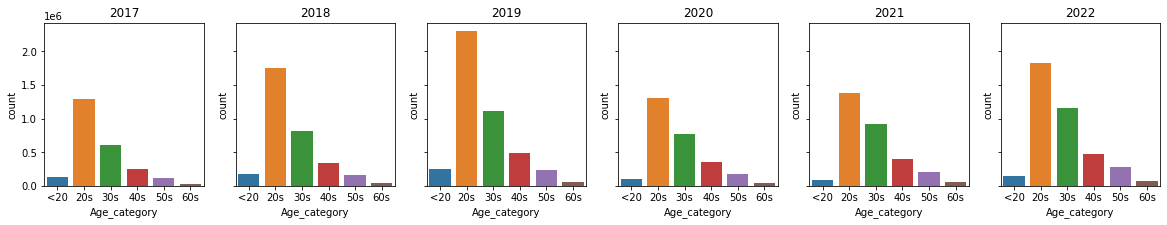

In [57]:
# Move age column next to borth year column
fig, axs = plt.subplots(ncols=6, figsize=(20, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x="Age_category", data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

## Age by Gender

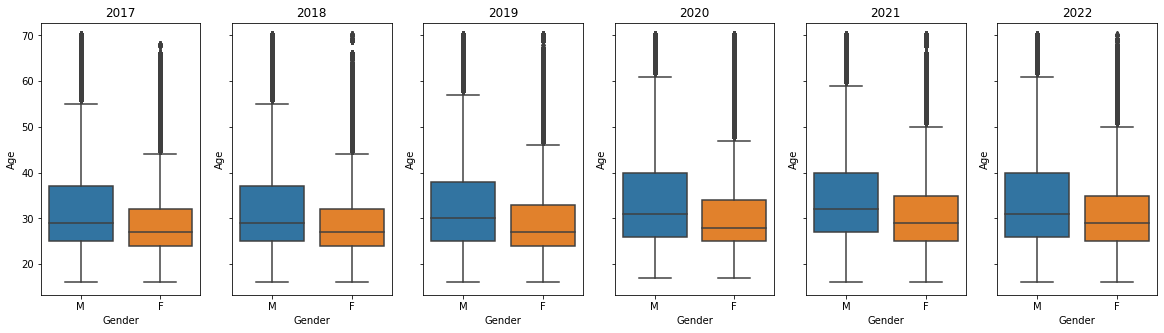

In [58]:
fig, axs = plt.subplots(ncols=6, figsize=(20, 5), sharey=True)
for i in range(len(years)):
    sns.boxplot(x="Gender", y="Age",  data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

## Day of the Week

Most popular days to use the system (Tuesday-Thursday)

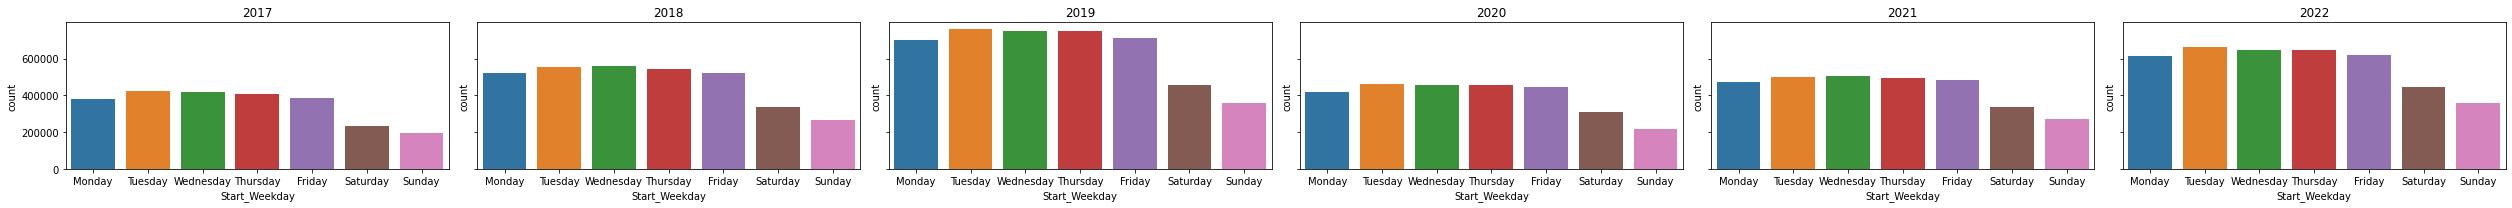

In [74]:
# 1 = Monday -> 7 = Sunday
weekday_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(ncols=6, figsize=(35, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x="Start_Weekday", data=years_df[i], ax=axs[i], order = weekday_name)
    axs[i].set_title(years[i])

fig.tight_layout()
plt.show()

Most popular hour to use the system 
* 8AM and 6 PM (rush hour: commuting times)
* 2PM (perhaps when school ends)

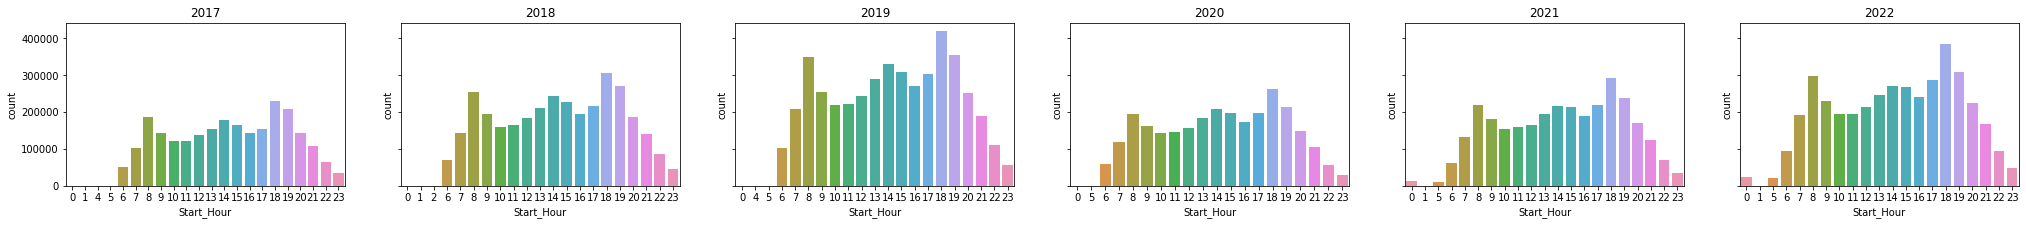

In [60]:
fig, axs = plt.subplots(ncols=6, figsize=(35, 3), sharey=True)
for i in range(len(years)):
    sns.countplot(x="Start_Hour", data=years_df[i], ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

Hour distribution by day of the week
* The patterns don't change per year, but the counts do.
* The work week (Mon-Fri) has the communting peaks
* Saturday has a morning & midday peak
* Sunday only has a midday peak

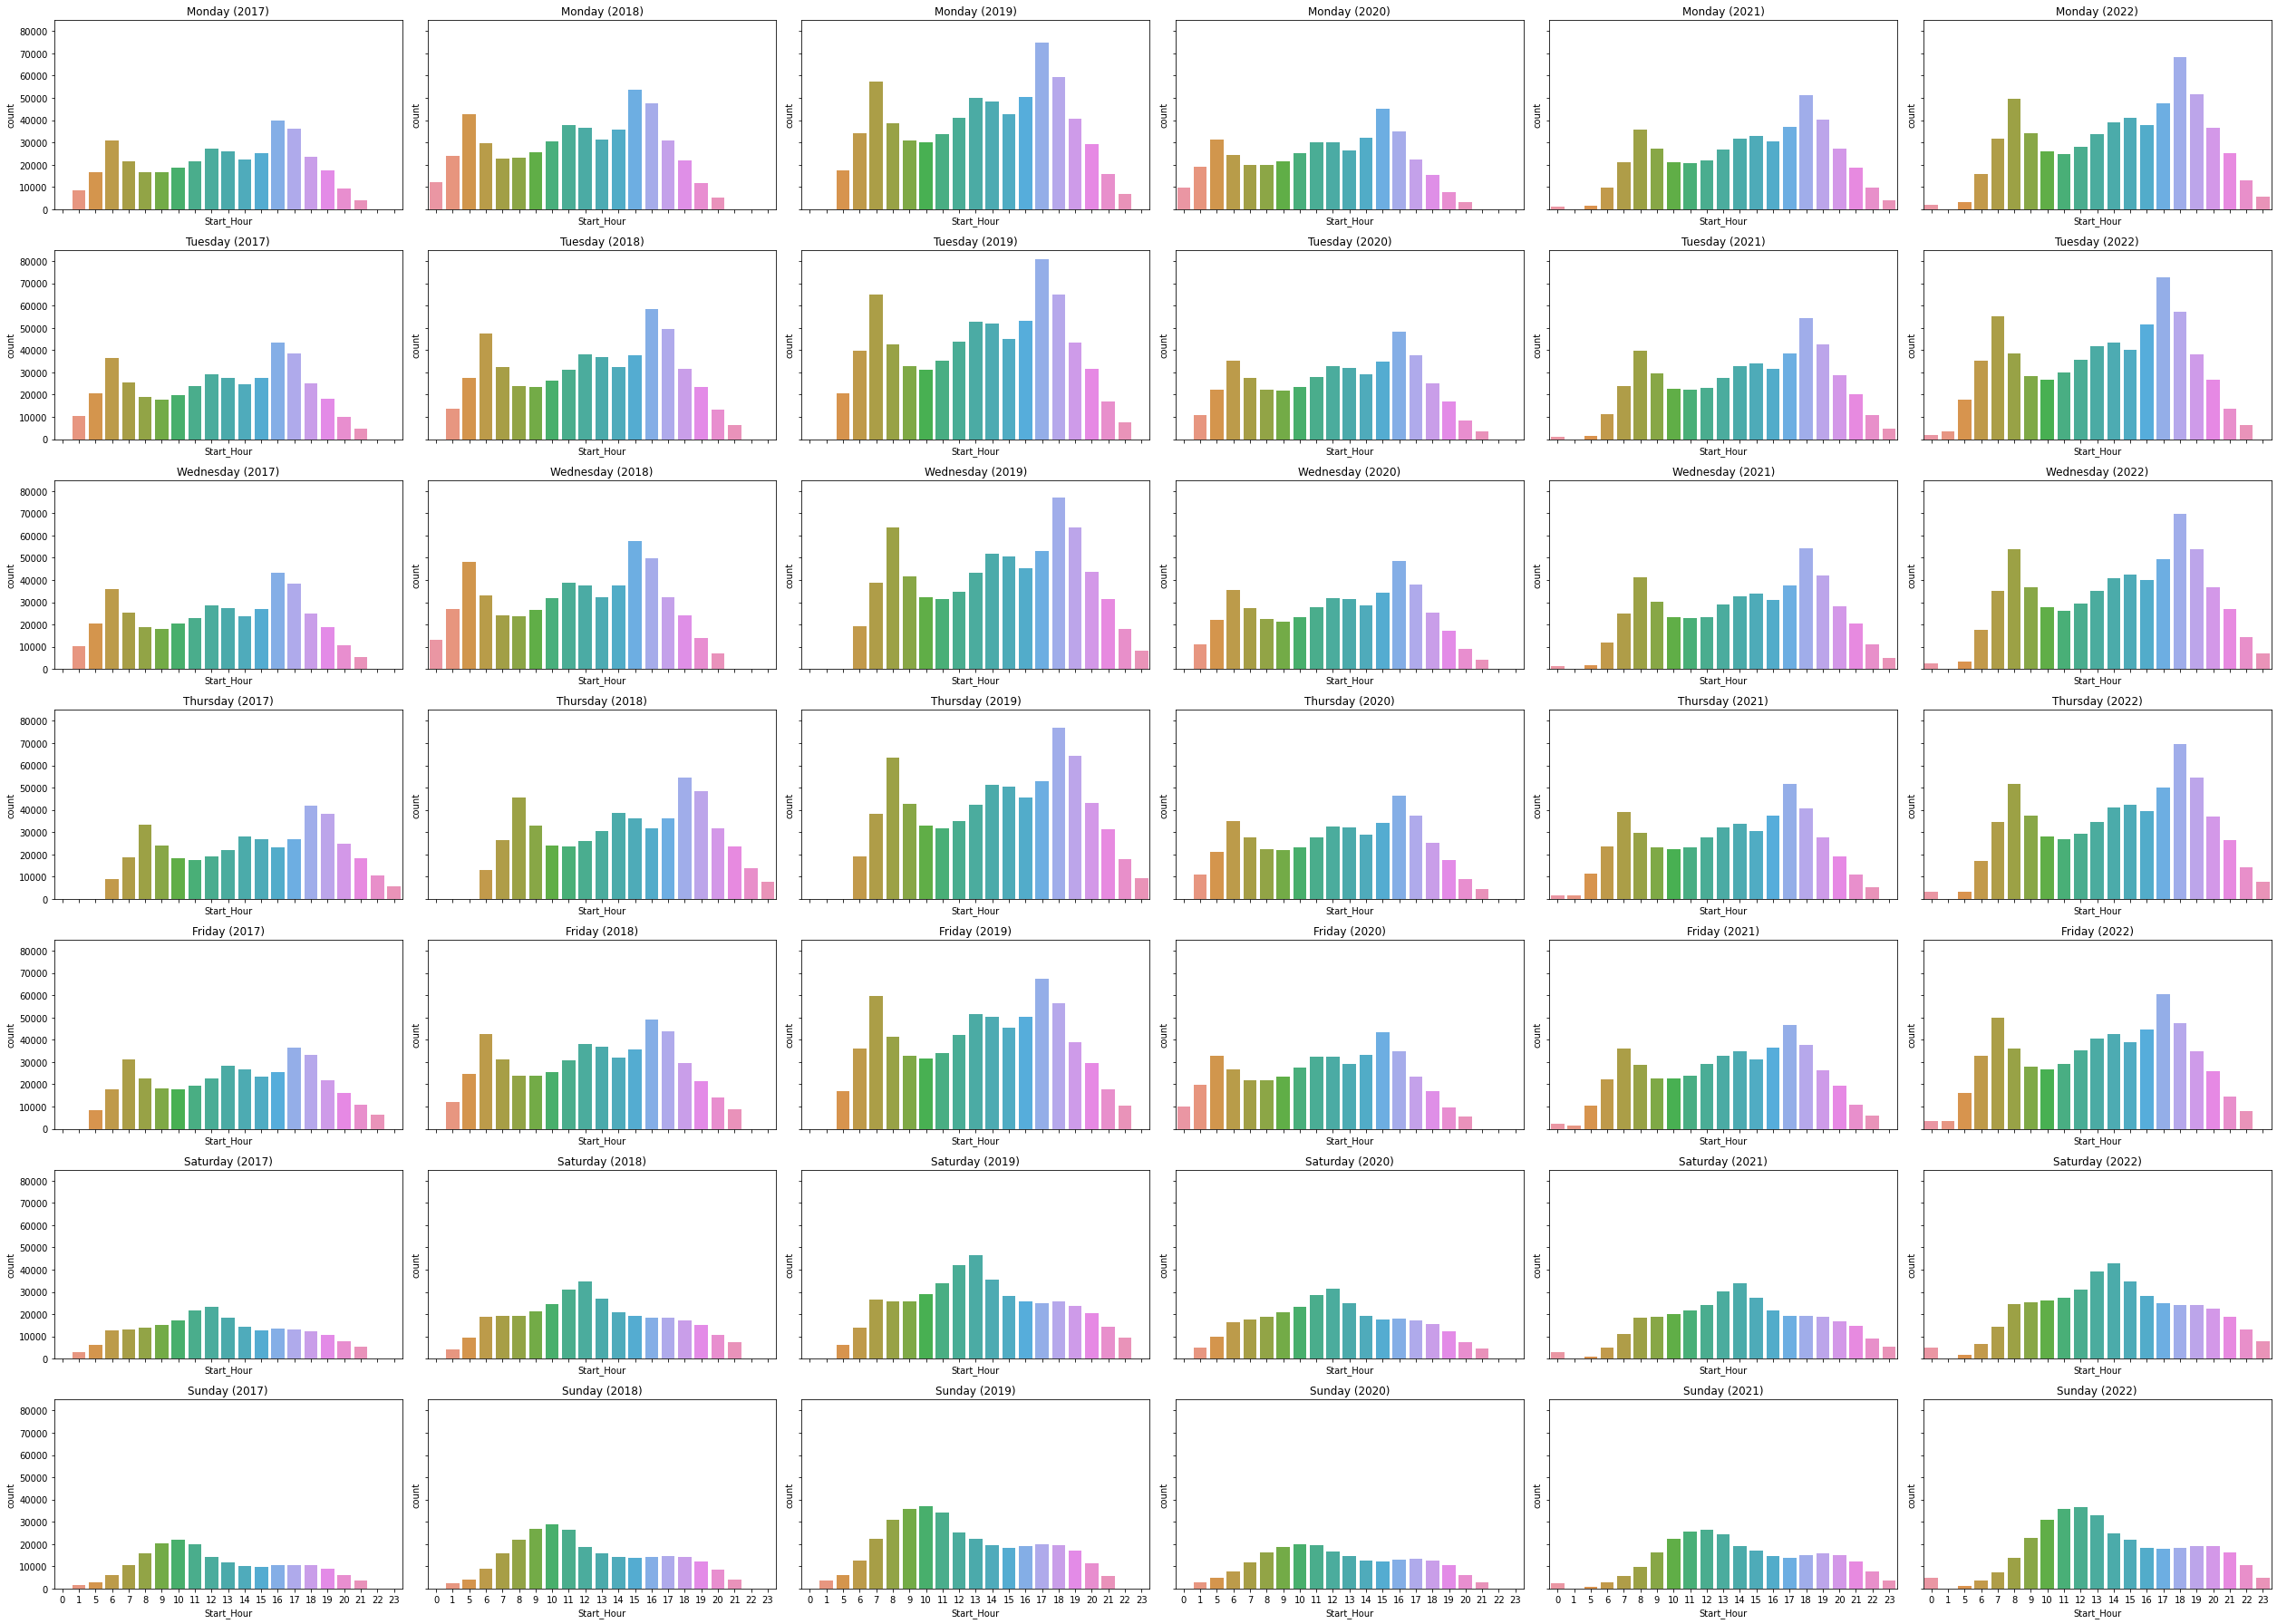

In [75]:
fig, axs = plt.subplots(nrows=7, ncols=6, figsize=(35, 25), sharex=True, sharey=True)
for i in range(len(years)):
    for j in range(len(weekday_name)):        
        sns.countplot(x="Start_Hour", 
                      data=years_df[i][years_df[i].Start_Weekday == weekday_name[j]], 
                      ax=axs[j,i])
        axs[j,i].set_title(weekday_name[j]+' ('+years[i]+')')

fig.tight_layout()
plt.show()

Mean/Median trip duration by day of the week

In [62]:
# annual mean by week day
pd.DataFrame([[years_df[i][years_df[i]['Start_Weekday'] == weekday_name[j]]['Duration'].mean() for i in range(len(years))] \
              for j in range(len(weekday_name))],
             columns=years, index = weekday_name).round(2)

,2017,2018,2019,2020,2021,2022
Monday,11.10,11.05,11.21,11.30,11.14,11.03
Tuesday,11.08,11.10,11.20,11.37,11.15,11.05
Wednesday,11.11,11.10,11.24,11.34,11.14,11.06
Thursday,11.05,11.11,11.19,11.31,11.12,11.00
Friday,11.09,11.13,11.25,11.34,11.13,11.04
Saturday,11.19,11.15,11.32,11.48,11.25,11.12
Sunday,13.85,13.57,13.57,12.69,13.30,13.40


In [63]:
# annual median by week day
pd.DataFrame([[years_df[i][years_df[i]['Start_Weekday'] == weekday_name[j]]['Duration'].median() for i in range(len(years))] \
              for j in range(len(weekday_name))],
             columns=years, index = weekday_name).round(2)

,2017,2018,2019,2020,2021,2022
Monday,9.53,9.55,9.72,9.85,9.75,9.62
Tuesday,9.53,9.62,9.75,9.95,9.75,9.65
Wednesday,9.58,9.62,9.78,9.92,9.75,9.63
Thursday,9.52,9.60,9.75,9.88,9.70,9.60
Friday,9.52,9.62,9.77,9.90,9.70,9.62
Saturday,9.53,9.57,9.73,9.93,9.75,9.60
Sunday,10.80,10.60,10.70,10.27,10.73,10.83


# Combine & Export Annual Data

The data is exported so that one can come back and conduct analyses during another session.

In [ ]:
# pd.concat(years_df, axis=0).to_csv("../../MiBici_Data/full_dataset.csv", index=False, encoding = 'utf-8')

In [67]:
# export data
# MiBici2017.to_csv('../../MiBici_Data/MiBici2017.csv', index=False, encoding = 'utf-8')
# MiBici2018.to_csv('../../MiBici_Data/MiBici2018.csv', index=False, encoding = 'utf-8')
# MiBici2019.to_csv('../../MiBici_Data/MiBici2019.csv', index=False, encoding = 'utf-8')
# MiBici2020.to_csv('../../MiBici_Data/MiBici2020.csv', index=False, encoding = 'utf-8')
# MiBici2021.to_csv('../../MiBici_Data/MiBici2021.csv', index=False, encoding = 'utf-8')
# MiBici2022.to_csv('../../MiBici_Data/MiBici2022.csv', index=False, encoding = 'utf-8')

Import data to conduct additional analyses.

In [66]:
# import data
MiBici2017 = pd.read_csv('../../MiBici_Data/MiBici2017.csv', encoding='utf-8')
MiBici2018 = pd.read_csv('../../MiBici_Data/MiBici2018.csv', encoding='utf-8')
MiBici2019 = pd.read_csv('../../MiBici_Data/MiBici2019.csv', encoding='utf-8')
MiBici2020 = pd.read_csv('../../MiBici_Data/MiBici2020.csv', encoding='utf-8')
MiBici2021 = pd.read_csv('../../MiBici_Data/MiBici2021.csv', encoding='utf-8')
MiBici2022 = pd.read_csv('../../MiBici_Data/MiBici2022.csv', encoding='utf-8')

In [67]:
# sort data into lists to make it easier to loop through and conduct analyses
years_df = [MiBici2017, MiBici2018, MiBici2019, MiBici2020, MiBici2021, MiBici2022]
years = ['2017', '2018', '2019', '2020', '2021', '2022']
weekday_name = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Research Questions

The goal of this section is to create smaller datasets that answer each research question

## Summary Statistics

This section arranges the MiBici dataframes to answer the following questions:
* The # of trips that start in each municpality
* The # of stations in each municpality
* The average trip duration by municpality
* Annual number of trips taken by municipality **(see Q1: Daily Trip Count)**
* The average # of trips taken per hour of day **(see Q3: Avg Workweek vs Weekend)**
* The # trips that start/end at each station **(see Q4: Station Popularity)**


### Number of Trips

In [69]:
num_trips_region = \
pd.DataFrame([i.groupby(["Start_City"]).size() for i in years_df], index=years).T.sum(axis=1)
num_trips_region

Start_City
Guadalajara    18510443
Tlaquepaque      331434
Zapopan         1216693
dtype: int64

### Number of Stations

In [70]:
# station location dataset
all_stations_new_df = pd.read_csv('../../MiBici_Data/nomenclatura_2022_12_updated.csv', encoding='utf-8')

In [71]:
# obtain count of rows by municipality
num_stations_region = \
all_stations_new_df.groupby(['city']).size()
num_stations_region

city
Guadalajara    231
Tlaquepaque     14
Zapopan         67
dtype: int64

### Avg Trip Dur 

Concatenate the trip durations across all MiBici datasets into one dataframe, group durations by municipality, then take the mean of each group

In [72]:
avg_tripdur_region = \
pd.concat([i[['Start_City', 'Duration']] for i in years_df], axis=0).groupby(['Start_City'])['Duration'].mean()
avg_tripdur_region

Start_City
Guadalajara    11.344505
Tlaquepaque    11.313013
Zapopan        11.404895
Name: Duration, dtype: float64

Mean duration across all dataframe

In [73]:
pd.concat([i['Duration'] for i in years_df], axis=0).mean()

11.347648471782504

Mean trip duration per year

In [73]:
pd.concat([i[['Duration']].mean() for i in years_df], axis=1, keys=years)

,2017,2018,2019,2020,2021,2022
Duration,11.31736,11.303497,11.418409,11.454076,11.338411,11.256773


Mean trip duration per year and city

In [70]:
pd.concat([i[['Start_City', 'Duration']].groupby(['Start_City'])['Duration'].mean() for i in years_df], axis=1, keys=years)

,2017,2018,2019,2020,2021,2022
Start_City,,,,,,
Guadalajara,11.310398,11.284574,11.393762,11.427903,11.359370,11.290743
Tlaquepaque,11.434713,11.486155,11.799038,11.577911,11.044765,10.430821
Zapopan,11.426002,11.670185,11.720928,11.817601,11.153783,11.032728


### Combine Data & Export

In [74]:
# combine three datasets above
counts_df = \
pd.concat([pd.DataFrame(num_trips_region).reset_index(drop=False),
           pd.DataFrame(num_stations_region).reset_index(drop=True),
           pd.DataFrame(avg_tripdur_region).reset_index(drop=True)
          ], axis=1)

In [75]:
# change columns
counts_df.columns = ['Region', 'Trips', 'Stations', 'Duration']

In [76]:
# add row with totals across regions
counts_df.loc[3,:] = counts_df.sum(axis=0)

In [77]:
counts_df

,Region,Trips,Stations,Duration
0,Guadalajara,18510443.0,231.0,11.344505
1,Tlaquepaque,331434.0,14.0,11.313013
2,Zapopan,1216693.0,67.0,11.404895
3,GuadalajaraTlaquepaqueZapopan,20058570.0,312.0,34.062413


In [78]:
# change last entry (row 3) for region and Duration (calculate mean dur across all datasets)
counts_df.iloc[3,0] = 'Total'
counts_df.iloc[3,3]  = pd.concat([i['Duration'] for i in years_df], axis=0).mean()

In [79]:
counts_df

,Region,Trips,Stations,Duration
0,Guadalajara,18510443.0,231.0,11.344505
1,Tlaquepaque,331434.0,14.0,11.313013
2,Zapopan,1216693.0,67.0,11.404895
3,Total,20058570.0,312.0,11.347648


In [80]:
counts_df.to_csv('../../MiBici_Data/Tableau_Datasets/Summary_Statistics/counts.csv', index=False, encoding = 'utf-8')

### Station Popularity

Number of trips starting and ending at each station is calculated for each year (also municipalities counts are calculated)

Create separate start & end station dataframes that contain the number of trips that start/end at each station

In [81]:
start_count_df = pd.DataFrame([i.groupby(['Start_City', 'Start_Name']).size() for i in years_df], index=years).T
end_count_df   = pd.DataFrame([i.groupby(['End_City', 'End_Name']).size()   for i in years_df], index=years).T

Create column for total trips over all years

In [82]:
start_count_df['Start_Count'] = start_count_df.sum(axis=1)
end_count_df['End_Count']     = end_count_df.sum(axis=1)

Reset the index so that station names are a column

In [83]:
start_count_df.reset_index(drop=False, inplace=True)
end_count_df.reset_index(drop=False, inplace=True)

Rename station name column headers

In [84]:
start_count_df.rename(columns={'Start_Name': 'Name'}, inplace=True)
end_count_df.rename(columns={'End_Name': 'Name'}, inplace=True)

start_count_df.rename(columns={'Start_City': 'City'}, inplace=True)
end_count_df.rename(columns={'End_City': 'City'}, inplace=True)

Drop all columns except station name, city, and count

In [85]:
start_count_df.drop(years, axis=1, inplace=True)
end_count_df.drop(years, axis=1, inplace=True)
end_count_df.drop(['City'], axis=1, inplace=True)

Merge dataframes side-by-side by station name column

In [86]:
full_station_count_df = pd.merge(start_count_df, end_count_df, on = 'Name', how='outer')

In [87]:
full_station_count_df

,City,Name,Start_Count,End_Count
0,Guadalajara,Av Manuel Acuña / C Fray Fco Frejes,42814.0,36098.0
1,Guadalajara,Av Manuel Acuña/C. Pablo Villaseñor,67539.0,57566.0
2,Guadalajara,Av. 16 de Sept. / C. Miguel Blanco,202642.0,235105.0
3,Guadalajara,Av. Américas / Av. López Mateos,88385.0,80876.0
4,Guadalajara,Av. Faro / Av. Las Rosas,37837.0,41450.0
...,...,...,...,...
303,Zapopan,C. Loyola / C. Organización,3331.0,2416.0
304,Zapopan,C. Organización / Av. Guadalupe,5795.0,3727.0
305,Zapopan,C. Prados los Pinos/ Av. Tepeyac,2488.0,1270.0
306,Zapopan,C. San Felipe Neri / Av. Guadalupe,3195.0,1594.0


Export dataframe

In [ ]:
# full_station_count_df.to_csv('../../MiBici_Data/Tableau_Datasets/Summary_Statistics/Station_Popularity.csv', index=False, encoding = 'utf-8')

## Trips vs COVID

### COVID Data

Read in the COVID data that contains the daily cases per municipality.

In [77]:
covid_df = pd.read_csv('../../MiBici_Data/COVID/Casos_Diarios_Municipio_Confirmados_20230103.csv', encoding='utf-8')

Select the appropriate data for the municipalities.

In [78]:
covid_df = covid_df.loc[covid_df.nombre.isin(['Guadalajara', 'Zapopan', 'San Pedro Tlaquepaque'])].T

Clean up COVID dataframe

In [79]:
# Make the row indicies into a new column
covid_df.reset_index(inplace=True)

# drop the first two rows
covid_df.drop([0,1], inplace=True)

# replace the column names
covid_df = covid_df.rename(columns = covid_df.iloc[0]).drop(covid_df.index[0])

# rename other columns
covid_df.rename(columns={'nombre': 'Date', 'San Pedro Tlaquepaque': 'Tlaquepaque'}, inplace=True)

# Convert Date column to datetime variable
covid_df.Date = pd.to_datetime(covid_df.Date)

# Reset index
covid_df.reset_index(drop=True, inplace=True)

# Create new column of cases across all municipalities
covid_df['Total'] = covid_df[['Zapopan', 'Guadalajara', 'Tlaquepaque']].sum(axis=1)

In [80]:
covid_df

,Date,Zapopan,Guadalajara,Tlaquepaque,Total
0,2020-02-26,0,0,0,0.0
1,2020-02-27,0,0,0,0.0
2,2020-02-28,0,0,0,0.0
3,2020-02-29,0,0,0,0.0
4,2020-03-01,0,0,0,0.0
...,...,...,...,...,...
1035,2022-12-27,39,94,18,151.0
1036,2022-12-28,54,108,19,181.0
1037,2022-12-29,47,64,11,122.0
1038,2022-12-30,22,60,18,100.0


Plot COVID cases by municipality

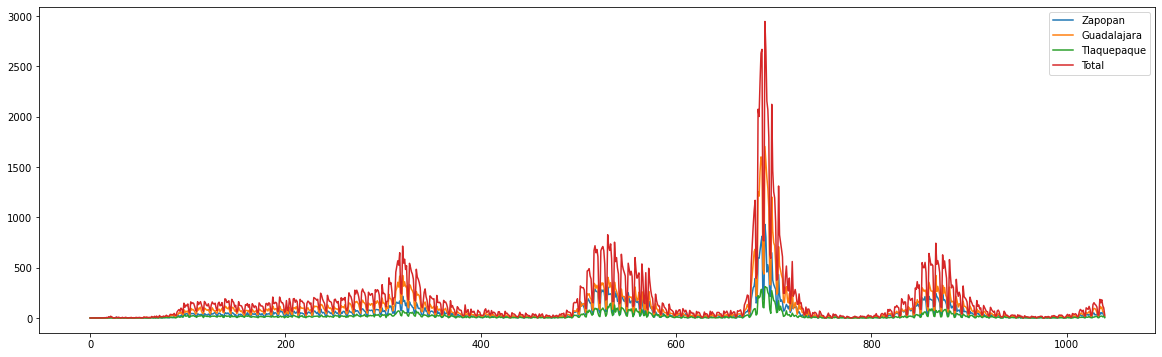

In [81]:
fig, ax = plt.subplots(figsize=(20, 6))

covid_df.Zapopan.plot(label="Zapopan", legend=True)
covid_df.Guadalajara.plot(label="Guadalajara", legend=True)
covid_df.Tlaquepaque.plot(label="Tlaquepaque", legend=True)
covid_df.Total.plot(label="Total", legend=True)

plt.show()

Create temp dataframe of zeros for COVID data before first data collection '2020-02-25' to later append to true covid data

In [82]:
temp_df = pd.DataFrame({'Date': pd.date_range('2017-01-01', '2022-12-31', freq='D'),
                        'Zapopan': [0]*len(pd.date_range('2017-01-01', '2022-12-31', freq='D')),
                        'Guadalajara': [0]*len(pd.date_range('2017-01-01', '2022-12-31', freq='D')),
                        'Tlaquepaque': [0]*len(pd.date_range('2017-01-01', '2022-12-31', freq='D')),
                        'Total': [0]*len(pd.date_range('2017-01-01', '2022-12-31', freq='D')),
                       })

In [83]:
temp_df

,Date,Zapopan,Guadalajara,Tlaquepaque,Total
0,2017-01-01,0,0,0,0
1,2017-01-02,0,0,0,0
2,2017-01-03,0,0,0,0
3,2017-01-04,0,0,0,0
4,2017-01-05,0,0,0,0
...,...,...,...,...,...
2186,2022-12-27,0,0,0,0
2187,2022-12-28,0,0,0,0
2188,2022-12-29,0,0,0,0
2189,2022-12-30,0,0,0,0


In [84]:
# concatenate temp data to COVID data
covid_df = pd.concat([temp_df, covid_df], axis=0)

In [85]:
# Reset indicies
covid_df.reset_index(drop=True, inplace=True)

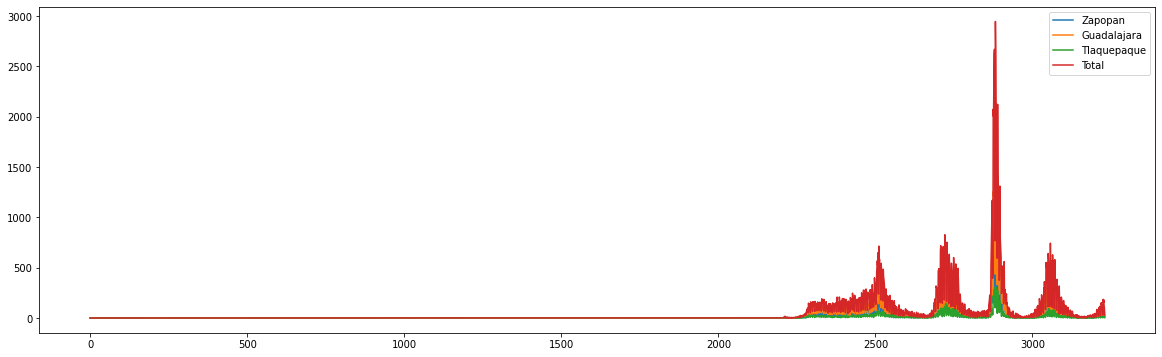

In [86]:
# Plot new dataframe
fig, ax = plt.subplots(figsize=(20, 6))

covid_df.Zapopan.plot(label="Zapopan", legend=True)
covid_df.Guadalajara.plot(label="Guadalajara", legend=True)
covid_df.Tlaquepaque.plot(label="Tlaquepaque", legend=True)
covid_df.Total.plot(label="Total", legend=True)

plt.show()

Convert data frame to long format for Tableau

In [98]:
covid_long_df = pd.melt(covid_df, id_vars='Date', value_vars=['Total', 'Guadalajara', 'Tlaquepaque', 'Zapopan'])

In [99]:
covid_long_df

,Date,variable,value
0,2017-01-01,Total,0.0
1,2017-01-02,Total,0.0
2,2017-01-03,Total,0.0
3,2017-01-04,Total,0.0
4,2017-01-05,Total,0.0
...,...,...,...
12919,2022-12-27,Zapopan,39
12920,2022-12-28,Zapopan,54
12921,2022-12-29,Zapopan,47
12922,2022-12-30,Zapopan,22


Export data

In [100]:
covid_df.to_csv('../../MiBici_Data/COVID/COVID_daily_cases_clean_07122022.csv', index=False, encoding='utf-8')
covid_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_1/COVID_daily_cases_clean_07122022.csv', index=False, encoding='utf-8')

covid_long_df.to_csv('../../MiBici_Data/COVID/COVID_daily_cases_clean_long_07122022.csv', index=False, encoding='utf-8')
covid_long_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_1/COVID_daily_cases_clean_long_07122022.csv', index=False, encoding='utf-8')

### Daily Bike Trip Counts

Loop through each file, save as dataframe, and obtain the row count for 2017-2022

In [101]:
output = pd.Series(name="Rows", dtype=int)

for file in years_df:
    df = file
    df['Start_Time'] = pd.to_datetime(df['Start_Time']).dt.strftime('%Y-%m-%d')
    output = pd.concat([output,df.groupby(['Start_City', 'Start_Time']).count().iloc[:,0]], axis=0)

In [102]:
output

(Guadalajara, 2017-01-01)    1178
(Guadalajara, 2017-01-02)    3727
(Guadalajara, 2017-01-03)    4466
(Guadalajara, 2017-01-04)    4720
(Guadalajara, 2017-01-05)    4953
                             ... 
(Zapopan, 2022-12-27)         700
(Zapopan, 2022-12-28)         646
(Zapopan, 2022-12-29)         641
(Zapopan, 2022-12-30)         533
(Zapopan, 2022-12-31)         278
Length: 6573, dtype: int64

Turn output into a formatted data frame for Tableau

In [103]:
# turn 'output' to dataframe
output_df = pd.DataFrame(output).reset_index(drop=False)

# spilt tuple into two columns of df and concat to output_df
output_df = pd.concat([output_df, 
                       pd.DataFrame(output_df['index'].tolist(), columns=['Region', 'Date'])
                      ], axis = 1)
           
# delete extra unformated tuple column
output_df.drop('index', axis=1, inplace=True)

# rename columns
output_df.columns = ['Count', 'Region', 'Date']

# conver Date column into datetime
output_df.Date = pd.to_datetime(output_df.Date)

In [104]:
output_df

,Count,Region,Date
0,1178,Guadalajara,2017-01-01
1,3727,Guadalajara,2017-01-02
2,4466,Guadalajara,2017-01-03
3,4720,Guadalajara,2017-01-04
4,4953,Guadalajara,2017-01-05
...,...,...,...
6568,700,Zapopan,2022-12-27
6569,646,Zapopan,2022-12-28
6570,641,Zapopan,2022-12-29
6571,533,Zapopan,2022-12-30


In [105]:
# add category for the total # trips across all regions
temp_df = pd.DataFrame(output_df.groupby(['Date'])['Count'].sum()).reset_index()
temp_df['Region'] = ['Total']*len(temp_df)

# rearrange order of columns
temp_df = temp_df.reindex(columns=['Count', 'Region', 'Date'])

Combine two dataframes to export

In [106]:
output_df = pd.concat([output_df, temp_df], axis=0).reset_index(drop=True)

Export data

In [107]:
output_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_1/daily_trip_count.csv', index=False, encoding='utf-8')

## Trip Duration

Summary Statistics

In [108]:
summary_avg_duration_df = \
pd.concat([MiBici2017.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2018.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2019.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2020.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2021.Duration.describe().apply(lambda x: '%.2f' % x),
           MiBici2022.Duration.describe().apply(lambda x: '%.2f' % x)
          ], axis=1, keys = years).T

In [109]:
summary_avg_duration_df

,count,mean,std,min,25%,50%,75%,max
2017,2447401.00,11.32,7.91,1.50,6.08,9.62,14.80,179.95
2018,3304562.00,11.30,7.64,1.50,6.12,9.67,14.78,179.95
2019,4486450.00,11.42,7.53,1.50,6.18,9.82,15.02,179.93
2020,2763470.00,11.45,7.41,1.50,6.20,9.93,15.10,179.97
2021,3059070.00,11.34,7.19,1.50,6.12,9.82,14.98,179.87
2022,3997634.00,11.26,7.14,1.50,6.08,9.72,14.90,179.97


In [110]:
# export sumary stats
# summary_avg_duration_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_2/Summary_Stat_Trip_Duration.csv', encoding = 'utf-8')

Loop through each dataset and create plots

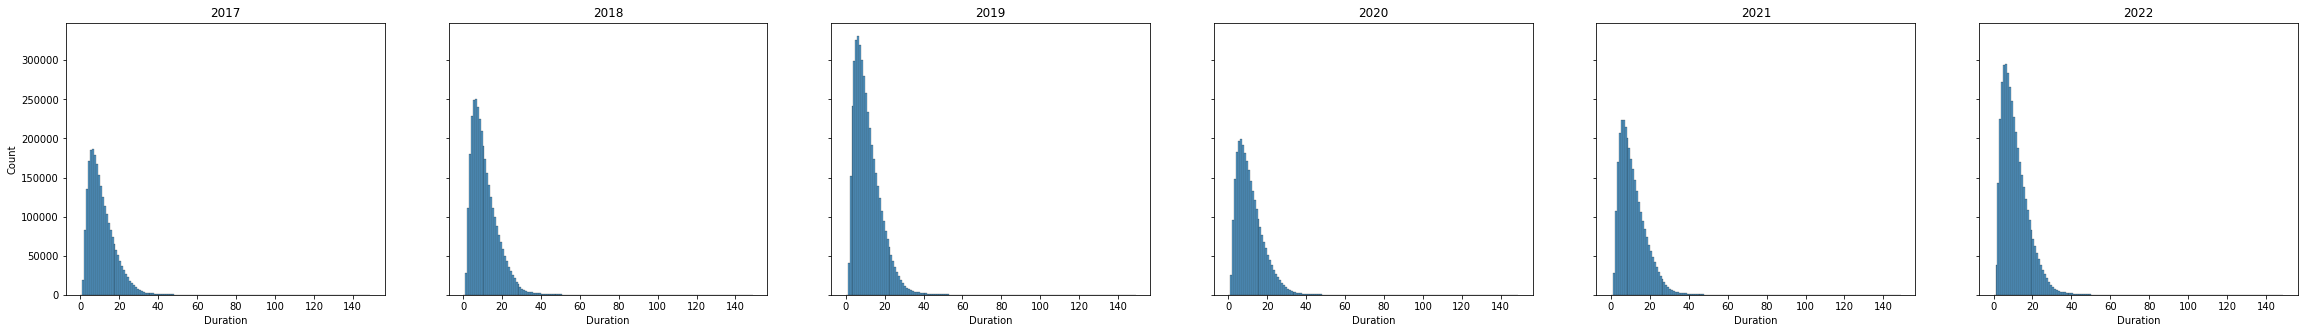

In [111]:
fig, axs = plt.subplots(ncols=6, figsize=(40, 5), sharey=True)
for i in range(len(years)):
    sns.histplot(years_df[i]['Duration'], bins=range(0,150,1), ax=axs[i])
    axs[i].set_title(years[i])
plt.show()

Create overlapping histograms and the bins & counts for each year

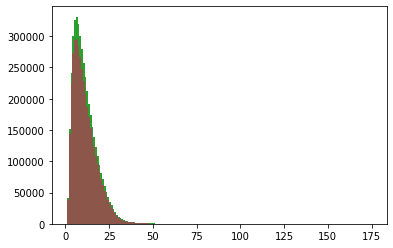

In [113]:
dur_hist_df = pd.DataFrame()

for i in range(len(years)):
    counts, bins, bars = plt.hist(years_df[i]['Duration'], 
                                  bins = range(1,176),
                                  range=(years_df[i]['Duration'].min(), years_df[i]['Duration'].max())
                                 )
    year = [years[i]]*(len(counts))
        
    dur_hist_df = pd.concat([dur_hist_df, pd.DataFrame({'counts':list(counts), 'bins':list(bins)[:-1], 'year':year})], axis=0)

In [115]:
# export data
dur_hist_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_2/Trip_Duration_histogram.csv', index=False, encoding='utf-8')

## Trips per Hour

### Weekend

The goal is to determine the average number of trips taken at each hour of the day over the 6 years worth of data.
* The data is split into workdays (M-F) and weekends (Sat/Sun)

Calculate the total # of trips per hour for each year

In [91]:
# create subset of yearly dataframes that only contains trips that occur on saturday or sunday
Avg_weekend_df = pd.DataFrame([years_df[i].loc[(years_df[i]['Start_Weekday'] == 'Saturday') | (years_df[i]['Start_Weekday'] == 'Sunday')].groupby('Start_Hour').size()   \
                               for i in range(len(years)) 
                              ], index=years).T

Sum across each row to get the total # trips over all 6 years

In [92]:
Avg_weekend_df['Sum'] = Avg_weekend_df.sum(axis=1)

In [93]:
Avg_weekend_df

,2017,2018,2019,2020,2021,2022,Sum
Start_Hour,,,,,,,
0,2.0,5.0,12.0,7.0,5355.0,10053.0,15434.0
6,4551.0,6591.0,9985.0,7557.0,7554.0,10282.0,46520.0
7,9022.0,13481.0,20171.0,14745.0,16527.0,21676.0,95622.0
8,18883.0,27776.0,39152.0,24310.0,28245.0,38147.0,176513.0
9,24032.0,35116.0,47951.0,29572.0,35412.0,47816.0,219899.0
10,29550.0,41214.0,56907.0,35125.0,42274.0,57092.0,262162.0
11,35138.0,48053.0,65032.0,39865.0,47491.0,63130.0,298709.0
12,39352.0,53526.0,70894.0,43155.0,50668.0,67708.0,325303.0
13,41442.0,57525.0,76047.0,47951.0,54473.0,71931.0,349369.0


Add in rows for missing hours
* Replace all `NaN` with 0
* Add row for 2h, 3h, 4h

In [94]:
Avg_weekend_df = Avg_weekend_df.fillna(0)

s = pd.DataFrame([0]*7, index=Avg_weekend_df.columns).T

s.index = [2]
Avg_weekend_df = pd.concat([Avg_weekend_df, s], axis=0)
s.index = [3]
Avg_weekend_df = pd.concat([Avg_weekend_df, s], axis=0)
s.index = [4]
Avg_weekend_df = pd.concat([Avg_weekend_df, s], axis=0)

Avg_weekend_df.sort_index()

,2017,2018,2019,2020,2021,2022,Sum
0,2.0,5.0,12.0,7.0,5355.0,10053.0,15434.0
1,0.0,0.0,0.0,0.0,3.0,2.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,1640.0,3206.0,4847.0
6,4551.0,6591.0,9985.0,7557.0,7554.0,10282.0,46520.0
7,9022.0,13481.0,20171.0,14745.0,16527.0,21676.0,95622.0
8,18883.0,27776.0,39152.0,24310.0,28245.0,38147.0,176513.0
9,24032.0,35116.0,47951.0,29572.0,35412.0,47816.0,219899.0


Divide each Year column by the number of weekends in a year to get the average # trips per hour.
* There are 52 weeks in a year and 2 days in a weekend.
* I assume that each year is the same so 52*2 = 104 days of the year are weekends

In [95]:
Avg_weekend_df.loc[:, years] = Avg_weekend_df.loc[:, years]/(104)

<AxesSubplot: >

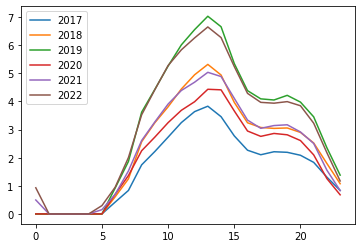

In [96]:
(Avg_weekend_df.loc[:, years]/(104)).sort_index().plot()

Divide the `Sum` column by the number of weekends over the 6 years to get the average.
* There are 52 weeks in a year and 2 days in a weekend.
* I assume that each year is the same so 52*2 = 104 days of the year are weekends
* I have 6 years worth of data (104*6)

In [97]:
Avg_weekend_df['Avg'] = Avg_weekend_df['Sum']/(104*6)

<AxesSubplot: >

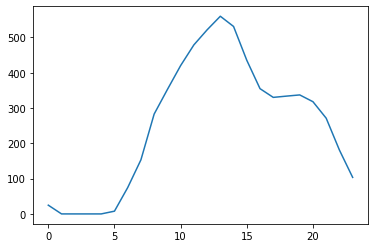

In [98]:
Avg_weekend_df['Avg'].sort_index().plot()

In [99]:
Avg_weekend_df

,2017,2018,2019,2020,2021,2022,Sum,Avg
0,0.019231,0.048077,0.115385,0.067308,51.490385,96.663462,15434.0,24.733974
6,43.759615,63.375000,96.009615,72.663462,72.634615,98.865385,46520.0,74.551282
7,86.750000,129.625000,193.951923,141.778846,158.913462,208.423077,95622.0,153.240385
8,181.567308,267.076923,376.461538,233.750000,271.586538,366.798077,176513.0,282.873397
9,231.076923,337.653846,461.067308,284.346154,340.500000,459.769231,219899.0,352.402244
10,284.134615,396.288462,547.182692,337.740385,406.480769,548.961538,262162.0,420.131410
11,337.865385,462.048077,625.307692,383.317308,456.644231,607.019231,298709.0,478.700321
12,378.384615,514.673077,681.673077,414.951923,487.192308,651.038462,325303.0,521.318910
13,398.480769,553.125000,731.221154,461.067308,523.778846,691.644231,349369.0,559.886218
14,359.701923,513.846154,692.403846,459.019231,508.240385,652.375000,331301.0,530.931090


### Workweek

Calculate the total # of trips per hour for each year

In [134]:
# create subset of yearly dataframes that only contains trips that occur mon-fri
Avg_workweek_df = pd.DataFrame([years_df[i].loc[(years_df[i]['Start_Weekday'] != 'Saturday') & (years_df[i]['Start_Weekday'] != 'Sunday')].groupby('Start_Hour').size()   \
                                for i in range(len(years)) 
                               ], index=years).T

Sum across each row to get the total # trips over all 6 years

In [135]:
Avg_workweek_df['Sum'] = Avg_workweek_df.sum(axis=1)

In [136]:
Avg_workweek_df

,2017,2018,2019,2020,2021,2022,Sum
Start_Hour,,,,,,,
0,11.0,11.0,24.0,4.0,7780.0,13194.0,21024.0
1,3.0,1.0,NaN,NaN,4.0,4.0,12.0
4,1.0,NaN,3.0,NaN,NaN,NaN,4.0
5,1.0,NaN,18.0,1.0,8245.0,17050.0,25315.0
6,45911.0,63832.0,93125.0,52115.0,54440.0,84161.0,393584.0
7,94525.0,129389.0,186858.0,104249.0,115259.0,169579.0,799859.0
8,167287.0,226364.0,308912.0,169750.0,191988.0,260096.0,1324397.0
9,118801.0,159071.0,206590.0,133553.0,145315.0,182770.0,946100.0
10,90894.0,119016.0,161809.0,108782.0,113011.0,137666.0,731178.0


* Replace all `NaN` with 0
* Add row for 3h

In [137]:
Avg_workweek_df = Avg_workweek_df.fillna(0)

s = pd.DataFrame([0]*7, index=Avg_workweek_df.columns).T
s.index = [3]
Avg_workweek_df = pd.concat([Avg_workweek_df, s], axis=0)

Avg_workweek_df

,2017,2018,2019,2020,2021,2022,Sum
0,11.0,11.0,24.0,4.0,7780.0,13194.0,21024.0
1,3.0,1.0,0.0,0.0,4.0,4.0,12.0
4,1.0,0.0,3.0,0.0,0.0,0.0,4.0
5,1.0,0.0,18.0,1.0,8245.0,17050.0,25315.0
6,45911.0,63832.0,93125.0,52115.0,54440.0,84161.0,393584.0
7,94525.0,129389.0,186858.0,104249.0,115259.0,169579.0,799859.0
8,167287.0,226364.0,308912.0,169750.0,191988.0,260096.0,1324397.0
9,118801.0,159071.0,206590.0,133553.0,145315.0,182770.0,946100.0
10,90894.0,119016.0,161809.0,108782.0,113011.0,137666.0,731178.0
11,87389.0,117381.0,156099.0,106897.0,110815.0,130983.0,709564.0


Divide each `Year` column by the number of work weeks in a year to get the average.
* There are 52 weeks in a year and 5 days in a work week.
* I assume that each year is the same so 52*5 = 260 days

In [138]:
Avg_workweek_df.loc[:, years] = Avg_workweek_df.loc[:, years]/(260)

<AxesSubplot: >

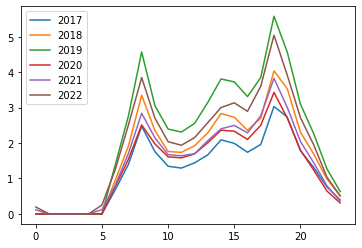

In [139]:
(Avg_workweek_df.loc[:, years]/(260)).sort_index().plot()

Divide the `Sum` column by the number of work weeks over the 6 years to get the average.
* There are 52 weeks in a year and 5 days in a work week.
* I assume that each year is the same so 52*5 = 260 days
* I have 6 years worth of data (260*6)

In [140]:
Avg_workweek_df['Avg'] = Avg_workweek_df['Sum']/(260*6)

<AxesSubplot: >

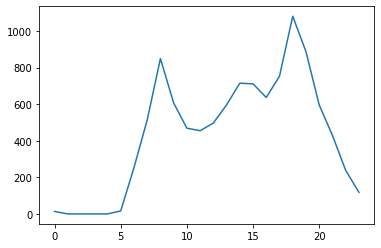

In [141]:
Avg_workweek_df['Avg'].sort_index().plot()

In [142]:
Avg_workweek_df

,2017,2018,2019,2020,2021,2022,Sum,Avg
0,0.042308,0.042308,0.092308,0.015385,29.923077,50.746154,21024.0,13.476923
1,0.011538,0.003846,0.000000,0.000000,0.015385,0.015385,12.0,0.007692
4,0.003846,0.000000,0.011538,0.000000,0.000000,0.000000,4.0,0.002564
5,0.003846,0.000000,0.069231,0.003846,31.711538,65.576923,25315.0,16.227564
6,176.580769,245.507692,358.173077,200.442308,209.384615,323.696154,393584.0,252.297436
7,363.557692,497.650000,718.684615,400.957692,443.303846,652.226923,799859.0,512.730128
8,643.411538,870.630769,1188.123077,652.884615,738.415385,1000.369231,1324397.0,848.972436
9,456.926923,611.811538,794.576923,513.665385,558.903846,702.961538,946100.0,606.474359
10,349.592308,457.753846,622.342308,418.392308,434.657692,529.484615,731178.0,468.703846
11,336.111538,451.465385,600.380769,411.142308,426.211538,503.780769,709564.0,454.848718


### Combine Datasets & Export

In [143]:
# Delete sum columns
Avg_workweek_df.drop(['Sum','Avg'], axis=1, inplace=True)
Avg_weekend_df.drop(['Sum','Avg'], axis=1, inplace=True)

In [144]:
# Make wide dataframes into long dataframes
Avg_workweek_long_df = \
pd.melt(Avg_workweek_df.rename_axis('Start_Hour').reset_index(drop=False), id_vars='Start_Hour', 
        value_vars=['2017', '2018', '2019', '2020', '2021', '2022'])

Avg_weekend_long_df = \
pd.melt(Avg_weekend_df.rename_axis('Start_Hour').reset_index(drop=False), id_vars='Start_Hour', 
        value_vars=['2017', '2018', '2019', '2020', '2021', '2022'])

In [145]:
Avg_workweek_long_df.head(5)

,Start_Hour,variable,value
0,0,2017,0.042308
1,1,2017,0.011538
2,4,2017,0.003846
3,5,2017,0.003846
4,6,2017,176.580769


In [146]:
# Rename columns
Avg_workweek_long_df.rename(columns={'variable':'Year', 'value':'Count'}, inplace=True)
Avg_weekend_long_df.rename(columns={'variable':'Year', 'value':'Count'}, inplace=True)

In [147]:
Avg_workweek_long_df.head(5)

,Start_Hour,Year,Count
0,0,2017,0.042308
1,1,2017,0.011538
2,4,2017,0.003846
3,5,2017,0.003846
4,6,2017,176.580769


In [148]:
# Add additional column to differentiate between weekend/workweek
Avg_workweek_long_df['Week_Period'] = ['Workweek']*len(Avg_workweek_long_df)

Avg_weekend_long_df['Week_Period'] = ['Weekend']*len(Avg_weekend_long_df)

In [149]:
Avg_workweek_long_df.head(5)

,Start_Hour,Year,Count,Week_Period
0,0,2017,0.042308,Workweek
1,1,2017,0.011538,Workweek
2,4,2017,0.003846,Workweek
3,5,2017,0.003846,Workweek
4,6,2017,176.580769,Workweek


In [150]:
# export data
pd.concat([Avg_workweek_long_df, Avg_weekend_long_df], axis=0) \
 .to_csv('../../MiBici_Data/Tableau_Datasets/Question_3/AvgTrip_PerHour_Annual.csv', index=False, encoding = 'utf-8')

## Popular Stations/Routes

### Start Station

Obtain all info about start station and calculate the number of trips per year that starts at each station

In [225]:
startStation_pop_df = \
pd.concat([years_df[i].groupby(["Start_City", "Start_Neighborhood", "Start_Name", "Start_Latitude", "Start_Longitude"]).size()  \
                      .reset_index(name = "Number of Trips")    \
                      .sort_values("Number of Trips", ascending = False) \
                      .reset_index(drop=True)   \
              for i in range(len(years)) 
          ], axis=0, keys=years)

In [226]:
startStation_pop_df

Start_City  Start_Neighborhood  \
2017 0    Guadalajara  Las Nueve Esquinas   
     1    Guadalajara           Americana   
     2    Guadalajara  Guadalajara Centro   
     3    Guadalajara    Capilla de Jesús   
     4    Guadalajara           Americana   
...               ...                 ...   
2022 295      Zapopan            El Vigía   
     296      Zapopan      Zapopan Centro   
     297  Guadalajara  Jardines de la Paz   
     298      Zapopan       Belenes Norte   
     299  Tlaquepaque            San Juan   

                                   Start_Name  Start_Latitude  \
2017 0      Lopez Cotilla/ Marcos Castellanos       20.674087   
     1    C. Constancio Hernández/ Av. Juaréz       20.674721   
     2    C. Pedro Moreno / Calz. Federalismo       20.675746   
     3       Calz. Federalismo / C. J. Angulo       20.681984   
     4           Av. La Paz / Av. Federalismo       20.669955   
...                                       ...             ...   
2022 295           C. del Pial / C. del Vigía       20.732450   
     296    C. Pino Suárez / C. López Cotilla       20.726558   
     297       C. Caballerango / C. Caporales       20.645040   
     298              C. Plata / Av. Laureles       20.735274   
     299            C. Zalatitán / C. Jalisco       20.641880   

          Start_Longitude  Number of Trips  
2017 0        -103.356320            48821  
     1        -103.358548            46606  
     2        -103.354579            42049  
     3        -103.353835            37804  
     4        -103.355032            36842  
...                   ...              ...  
2022 295      -103.392910             1610  
     296      -103.389242             1183  
     297      -103.305180             1080  
     298      -103.399746             1030  
     299      -103.306510              838  

[1664 rows x 6 columns]

In [227]:
startStation_pop_df.reset_index(drop=False, inplace=True)      # reset indices, save old indices
startStation_pop_df.rename(columns={'level_0':'Year'}, inplace=True)   # change level 0 indices to year
startStation_pop_df.drop('level_1', axis=1, inplace=True)      # remove level 1 indices

In [228]:
startStation_pop_df.head(5)

,Year,Start_City,Start_Neighborhood,Start_Name,Start_Latitude,Start_Longitude,Number of Trips
0,2017,Guadalajara,Las Nueve Esquinas,Lopez Cotilla/ Marcos Castellanos,20.674087,-103.356320,48821
1,2017,Guadalajara,Americana,C. Constancio Hernández/ Av. Juaréz,20.674721,-103.358548,46606
2,2017,Guadalajara,Guadalajara Centro,C. Pedro Moreno / Calz. Federalismo,20.675746,-103.354579,42049
3,2017,Guadalajara,Capilla de Jesús,Calz. Federalismo / C. J. Angulo,20.681984,-103.353835,37804
4,2017,Guadalajara,Americana,Av. La Paz / Av. Federalismo,20.669955,-103.355032,36842


In [231]:
# save df in new df
startStation_pop_df_total = startStation_pop_df.copy()

# change new start city to total
startStation_pop_df_total['Start_City'] = ['Total']*len(startStation_pop_df_total)     

# concat two dfs
startStation_pop_df = pd.concat([startStation_pop_df, startStation_pop_df_total], axis=0)   
startStation_pop_df.reset_index(drop=False, inplace=True)

In [232]:
startStation_pop_df

,index,Year,Start_City,Start_Neighborhood,Start_Name,Start_Latitude,Start_Longitude,Number of Trips
0,0,2017,Guadalajara,Las Nueve Esquinas,Lopez Cotilla/ Marcos Castellanos,20.674087,-103.356320,48821
1,1,2017,Guadalajara,Americana,C. Constancio Hernández/ Av. Juaréz,20.674721,-103.358548,46606
2,2,2017,Guadalajara,Guadalajara Centro,C. Pedro Moreno / Calz. Federalismo,20.675746,-103.354579,42049
3,3,2017,Guadalajara,Capilla de Jesús,Calz. Federalismo / C. J. Angulo,20.681984,-103.353835,37804
4,4,2017,Guadalajara,Americana,Av. La Paz / Av. Federalismo,20.669955,-103.355032,36842
...,...,...,...,...,...,...,...,...
3323,1659,2022,Total,El Vigía,C. del Pial / C. del Vigía,20.732450,-103.392910,1610
3324,1660,2022,Total,Zapopan Centro,C. Pino Suárez / C. López Cotilla,20.726558,-103.389242,1183
3325,1661,2022,Total,Jardines de la Paz,C. Caballerango / C. Caporales,20.645040,-103.305180,1080
3326,1662,2022,Total,Belenes Norte,C. Plata / Av. Laureles,20.735274,-103.399746,1030


Export data

In [233]:
startStation_pop_df.to_csv("../../MiBici_Data/Tableau_Datasets/Question_4/popular_start_stations.csv", index=False, encoding='utf-8')

### Google Maps Routes

#### Most Common Routes 

Obtain the 30 most common routes per year

In [179]:
# loop through each yearly Mibici df and obtain the top 30 routes, feed each year into a list and conver into a dataframe
overall_stations_df = \
pd.concat([years_df[i].groupby(["Start_Name","End_Name"]).size()  \
                      .reset_index(name = "Number of Trips")    \
                      .sort_values("Number of Trips", ascending = False) \
                      .reset_index(drop=True).head(30)   \
              for i in range(len(years)) 
          ], axis=0, keys=years)

In [180]:
# turn hierarchical indices into column for year
overall_stations_df.reset_index(inplace=True)

# delete index column of [0:14] per year
overall_stations_df.drop('level_1', axis=1, inplace=True)

# rename 'level_0' column to year
overall_stations_df.rename(columns={'level_0': 'Year'}, inplace=True)

In [181]:
# overall_stations_df['Start_City'] = 'Total'
overall_stations_df.insert(1, 'Start_City', 'Total') 

In [182]:
overall_stations_df

,Year,Start_City,Start_Name,End_Name,Number of Trips
0,2017,Total,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955
1,2017,Total,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745
2,2017,Total,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2478
3,2017,Total,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2424
4,2017,Total,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2329
...,...,...,...,...,...
175,2022,Total,Av. Alcalde / C. Hospital,Av. Juárez / Av. 16 de Septiembre,2231
176,2022,Total,Av. Juárez / Av. 16 de Septiembre,Av. Alcalde / C. Hospital,2224
177,2022,Total,Calz. Federalismo / C. J. Angulo,C. Pedro Moreno / Calz. Federalismo,2219
178,2022,Total,C. Miguel Hidalgo / Calz. Revolució,C. Independencia / C. Allende,2202


Per city per year

In [183]:
# for each year of data, get counts for each unique route
# rename the counts column to 'Number of trips'
# sort dataframe by # of trips max to min
# save the indicies: City, Start/End Name as columns
# return the top 50 routes in each city
muni_stations_df = \
pd.concat([years_df[i].groupby(["Start_City", "Start_Name", "End_Name"]).size() \
                      .reset_index(name = "Number of Trips")                    \
                      .sort_values("Number of Trips", ascending = False)        \
                      .reset_index(drop=False)                                  \
                      .groupby('Start_City').head(30)                             
           for i in range(len(years)) 
          ], axis=0, keys=years).reset_index(drop=False)

In [184]:
# delete index column of [0:14] per year
muni_stations_df.drop(['level_1', 'index'], axis=1, inplace=True)

# rename 'level_0' column to year
muni_stations_df.rename(columns={'level_0': 'Year'}, inplace=True)

In [185]:
muni_stations_df

,Year,Start_City,Start_Name,End_Name,Number of Trips
0,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955
1,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745
2,2017,Guadalajara,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2478
3,2017,Guadalajara,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2424
4,2017,Guadalajara,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2329
...,...,...,...,...,...
535,2022,Tlaquepaque,C. Progreso / C. Juárez,Blvrd. García Barragán / C. Río Tajo,400
536,2022,Tlaquepaque,C. Juárez / Av. Niños Héroes,C. Rio Panuco / Blvrd. García B.,399
537,2022,Tlaquepaque,Blvrd. García Barragán / Donato Guerra,C. Corregidora / Blvrd. García B.,394
538,2022,Tlaquepaque,C. Jalisco / C. Hidalgo,C. Miguel Hidalgo / Calz. Revolució,385


Use match index to obtain additional info for each start/end station

In [186]:
# combine two dataframes (by city & overall)
pop_stations_df = pd.concat([muni_stations_df, overall_stations_df], axis=0).reset_index(drop=True)
pop_stations_df.rename(columns={'Start_City':'Category'},inplace=True)

In [187]:
pop_stations_df

,Year,Category,Start_Name,End_Name,Number of Trips
0,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955
1,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745
2,2017,Guadalajara,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2478
3,2017,Guadalajara,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2424
4,2017,Guadalajara,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2329
...,...,...,...,...,...
715,2022,Total,Av. Alcalde / C. Hospital,Av. Juárez / Av. 16 de Septiembre,2231
716,2022,Total,Av. Juárez / Av. 16 de Septiembre,Av. Alcalde / C. Hospital,2224
717,2022,Total,Calz. Federalismo / C. J. Angulo,C. Pedro Moreno / Calz. Federalismo,2219
718,2022,Total,C. Miguel Hidalgo / Calz. Revolució,C. Independencia / C. Allende,2202


In [188]:
# import station dataframe
all_stations_new_df = pd.read_csv('../../MiBici_Data/nomenclatura_2022_12_updated.csv', encoding='utf-8')

In [189]:
# Match index for STARTING Station
pop_stations_df = pop_stations_df.merge(all_stations_new_df, how='left', left_on='Start_Name', right_on='name')

# Rename columns for start station
pop_stations_df.rename(columns=({'latitude'      : 'Start_Latitude',  
                                 'longitude'     : 'Start_Longitude',
                                 'status'        : 'Start_Status',
                                 'geometry'      : 'Start_Geometry',
                                 'address'       : 'Start_Address',
                                 'city'          : 'Start_City',
                                 'neighbourhood' : 'Start_Neighborhood'}
                               ), inplace=True)

pop_stations_df.drop(['id', 'name', 'obcn', 'location'], axis=1, inplace=True)

In [190]:
pop_stations_df.head(5)

,Year,Category,Start_Name,End_Name,Number of Trips,Start_Latitude,Start_Longitude,Start_Status,Start_Geometry,Start_Address,Start_City,Start_Neighborhood
0,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas
1,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas
2,2017,Guadalajara,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2478,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana
3,2017,Guadalajara,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2424,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas
4,2017,Guadalajara,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2329,20.673321,-103.370571,IN_SERVICE,"20.673321,-103.370571","MiBici, Calle Marsella, 44140, Calle Marsella,...",Guadalajara,Obrera


In [191]:
# Match index for ENDING Stations
pop_stations_df = pop_stations_df.merge(all_stations_new_df, how='left', left_on='End_Name', right_on='name')

# Rename columns for start station
pop_stations_df.rename(columns=({'latitude'      : 'End_Latitude',  
                                 'longitude'     : 'End_Longitude',
                                 'status'        : 'End_Status',
                                 'geometry'      : 'End_Geometry',
                                 'address'       : 'End_Address',
                                 'city'          : 'End_City',
                                 'neighbourhood' : 'End_Neighborhood'}
                               ), inplace=True)

pop_stations_df.drop(['id', 'name', 'obcn', 'location'], axis=1, inplace=True)

In [192]:
pop_stations_df.head(5)

,Year,Category,Start_Name,End_Name,Number of Trips,Start_Latitude,Start_Longitude,Start_Status,Start_Geometry,Start_Address,Start_City,Start_Neighborhood,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood
0,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas
1,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas,20.687950,-103.333430,IN_SERVICE,"20.68795,-103.33343","909, Calle Sierra Nevada, 44340, Calle Sierra ...",Guadalajara,Independencia Oriente
2,2017,Guadalajara,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2478,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana
3,2017,Guadalajara,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2424,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas
4,2017,Guadalajara,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2329,20.673321,-103.370571,IN_SERVICE,"20.673321,-103.370571","MiBici, Calle Marsella, 44140, Calle Marsella,...",Guadalajara,Obrera,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas


In [193]:
# export data
pop_stations_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_4/popular_routes_count.csv', index=False, encoding = 'utf-8')

#### Route for Popular Trips

This function creates the google.maps url needed to obtain the directions between any two points


In [194]:
# Google API Key
API_Key = Path('../../MiBici_Data/GDirections_API_Key.txt').read_text()

# avoid highways and find directions for a cyclist
avoid = 'highway'
transport_mode = 'bicycling'

# Function
def google_directions(s_lat, s_lng, e_lat, e_lng, avd, trnsprt_mode, API_k):
    
    # build url address for directions
    url = "https://maps.googleapis.com/maps/api/directions/json?"     \
          + "origin=" + s_lat + "%2C" + s_lng                         \
          + "&destination=" + e_lat + "%2C" + e_lng                   \
          + "&avoid=" + avd                                           \
          + "&mode=" + trnsprt_mode                                   \
          + "&key=" + API_k
    
    payload={}
    headers = {}
    
    # Request access to the google apis webpage.
    response = requests.request("GET", url, headers=headers, data=payload)
    return response

Use google directions API function to obtain the lat/lng coordinates of top 30 routes per year & by category

In [195]:
list = []

# loop through each row, enter start/end lat/lng info into google maps to obtain bicycle route.
for i in pop_stations_df.index:
    
    # Request access to the google apis webpage. Enter lat/lng data for each route in df 
    response = google_directions(pop_stations_df['Start_Latitude'][i].astype('str'), 
                                 pop_stations_df['Start_Longitude'][i].astype('str'), 
                                 pop_stations_df['End_Latitude'][i].astype('str'), 
                                 pop_stations_df['End_Longitude'][i].astype('str'), 
                                 avoid, transport_mode, API_Key)
    
    # Obtain polyline of route and convert it into a list of tuple lat/lngs
    # append to list
    list.append(polyline.decode(response.json()['routes'][0]['overview_polyline']['points'])) 

# Clear API key
API_Key = ''

In [196]:
pop_stations_df['Route'] = pd.Series(list)

In [197]:
pop_stations_df.head(8)

,Year,Category,Start_Name,End_Name,Number of Trips,Start_Latitude,Start_Longitude,Start_Status,Start_Geometry,Start_Address,Start_City,Start_Neighborhood,End_Latitude,End_Longitude,End_Status,End_Geometry,End_Address,End_City,End_Neighborhood,Route
0,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas,"[(20.68465, -103.34526)]"
1,2017,Guadalajara,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas,20.687950,-103.333430,IN_SERVICE,"20.68795,-103.33343","909, Calle Sierra Nevada, 44340, Calle Sierra ...",Guadalajara,Independencia Oriente,"[(20.68465, -103.34526), (20.68464, -103.34544..."
2,2017,Guadalajara,C. Miguel Blanco / C. Penitenciaria,C. Miguel Blanco / C. Penitenciaria,2478,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana,20.672231,-103.355508,IN_SERVICE,"20.672231,-103.355508","MiBici, Miguel Blanco, 44170, Miguel Blanco, G...",Guadalajara,Americana,"[(20.6722, -103.35551)]"
3,2017,Guadalajara,Lopez Cotilla/ Marcos Castellanos,Lopez Cotilla/ Marcos Castellanos,2424,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas,"[(20.67407, -103.35632)]"
4,2017,Guadalajara,C. Marsella / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2329,20.673321,-103.370571,IN_SERVICE,"20.673321,-103.370571","MiBici, Calle Marsella, 44140, Calle Marsella,...",Guadalajara,Obrera,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas,"[(20.67332, -103.37055), (20.67368, -103.37056..."
5,2017,Guadalajara,C. Colonias / C. López Cotilla,Lopez Cotilla/ Marcos Castellanos,2226,20.674132,-103.366139,IN_SERVICE,"20.674132,-103.366139","129, Calle Colonias, 44140, Calle Colonias, Gu...",Guadalajara,Americana,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas,"[(20.67413, -103.36614), (20.6738, -103.36613)..."
6,2017,Guadalajara,Lopez Cotilla/ Marcos Castellanos,C. Colonias / C. López Cotilla,2217,20.674087,-103.356320,IN_SERVICE,"20.6740865,-103.3563196","771, Calle López Cotilla, 44100, Calle López C...",Guadalajara,Las Nueve Esquinas,20.674132,-103.366139,IN_SERVICE,"20.674132,-103.366139","129, Calle Colonias, 44140, Calle Colonias, Gu...",Guadalajara,Americana,"[(20.67407, -103.35632), (20.67412, -103.35548..."
7,2017,Guadalajara,Calz. Federalismo / C. J. Angulo,C. Juan Álvarez / C. Belén,2155,20.681984,-103.353835,IN_SERVICE,"20.681984,-103.353835","Calzada Federalismo, 44200, Guadalajara, Jalis...",Guadalajara,Capilla de Jesús,20.684650,-103.345260,IN_SERVICE,"20.68465,-103.34526","498, Calle Belén, 44280, Calle Belén, Guadalaj...",Guadalajara,Centro Barranquitas,"[(20.68204, -103.35383), (20.68204, -103.35375..."


Format dataframe for Tableau:
* A path ID for every unique path. 
* Order of Points column: index order of lat/lng per path
* Latitude and longitude coordinates for every location
* Route name
* number of trips

In [198]:
temp_df       = pd.DataFrame()
tab_routes_df = pd.DataFrame()

# loop through each row, for each route, create appropriate dataframe format and append to 'tab_routes_df'
for i in pop_stations_df.index:
    temp_df = pd.DataFrame(pop_stations_df.Route[i], columns = ['Latitude', 'Longitude'])
    temp_df['Order of Points'] = temp_df.index + 1
    temp_df['Path ID']         = pd.DataFrame([i + 1]*len(temp_df))
    temp_df['Line']            = pd.DataFrame([i + 1]*len(temp_df))
    temp_df['Start Name']      = pd.DataFrame([pop_stations_df['Start_Name'][i]]*len(temp_df))
    temp_df['End Name']        = pd.DataFrame([pop_stations_df['End_Name'][i]]*len(temp_df))
    temp_df['Number of Trips'] = pd.DataFrame([pop_stations_df['Number of Trips'][i]]*len(temp_df))
    temp_df['Year']            = pd.DataFrame([pop_stations_df['Year'][i]]*len(temp_df))
    temp_df['Category']        = pd.DataFrame([pop_stations_df['Category'][i]]*len(temp_df))
     
    tab_routes_df = pd.concat([tab_routes_df, temp_df], axis=0)
    
    temp_df = pd.DataFrame()

In [199]:
tab_routes_df

,Latitude,Longitude,Order of Points,Path ID,Line,Start Name,End Name,Number of Trips,Year,Category
0,20.68465,-103.34526,1,1,1,C. Juan Álvarez / C. Belén,C. Juan Álvarez / C. Belén,2955,2017,Guadalajara
0,20.68465,-103.34526,1,2,2,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,2017,Guadalajara
1,20.68464,-103.34544,2,2,2,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,2017,Guadalajara
2,20.68542,-103.34551,3,2,2,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,2017,Guadalajara
3,20.68557,-103.34552,4,2,2,C. Juan Álvarez / C. Belén,C. Monte Cáucaso / C. Sierra Nevada,2745,2017,Guadalajara
...,...,...,...,...,...,...,...,...,...,...
4,20.63913,-103.30417,5,719,719,C. Miguel Hidalgo / Calz. Revolució,C. Independencia / C. Allende,2202,2022,Total
5,20.63912,-103.30541,6,719,719,C. Miguel Hidalgo / Calz. Revolució,C. Independencia / C. Allende,2202,2022,Total
6,20.63917,-103.30803,7,719,719,C. Miguel Hidalgo / Calz. Revolució,C. Independencia / C. Allende,2202,2022,Total
7,20.63918,-103.30858,8,719,719,C. Miguel Hidalgo / Calz. Revolució,C. Independencia / C. Allende,2202,2022,Total


In [200]:
tab_routes_df.sort_values(['Year', 'Number of Trips'], ascending=False)

,Latitude,Longitude,Order of Points,Path ID,Line,Start Name,End Name,Number of Trips,Year,Category
0,20.72956,-103.38858,1,451,451,Av. J. Parres Arias / Prol. López C,Av. Periférico G. Morín / Av. J. Pa,7535,2022,Zapopan
1,20.72935,-103.38892,2,451,451,Av. J. Parres Arias / Prol. López C,Av. Periférico G. Morín / Av. J. Pa,7535,2022,Zapopan
2,20.72913,-103.38897,3,451,451,Av. J. Parres Arias / Prol. López C,Av. Periférico G. Morín / Av. J. Pa,7535,2022,Zapopan
3,20.72921,-103.38886,4,451,451,Av. J. Parres Arias / Prol. López C,Av. Periférico G. Morín / Av. J. Pa,7535,2022,Zapopan
4,20.73039,-103.38709,5,451,451,Av. J. Parres Arias / Prol. López C,Av. Periférico G. Morín / Av. J. Pa,7535,2022,Zapopan
...,...,...,...,...,...,...,...,...,...,...
5,20.63749,-103.31152,6,90,90,C. Zaragoza / C. Emilio Carranza,C. Juárez / Av. Niños Héroes,265,2017,Tlaquepaque
6,20.63764,-103.31542,7,90,90,C. Zaragoza / C. Emilio Carranza,C. Juárez / Av. Niños Héroes,265,2017,Tlaquepaque
7,20.63772,-103.31668,8,90,90,C. Zaragoza / C. Emilio Carranza,C. Juárez / Av. Niños Héroes,265,2017,Tlaquepaque
8,20.63841,-103.31660,9,90,90,C. Zaragoza / C. Emilio Carranza,C. Juárez / Av. Niños Héroes,265,2017,Tlaquepaque


Export data

In [201]:
tab_routes_df.to_csv('../../MiBici_Data/Tableau_Datasets/Question_4/map_routes_count.csv', index=False, encoding = 'utf-8')

# Conclusion

Ridership dipped after the statewide shutdown in New York, and rose again after reopening phases. 

We also were able to visualize the changing concentrations of stations traffic from 2019 to 2020 from our timed heatmap. 

From other map plots, we were able to see how in 2020, most popular stations were closer to parks and most popular trips consisted of many more loops, which may allude to more “joyrides” or rides taken for leisure or fun.


The applications of this analysis truly lie in understanding the changing dynamics of bike ridership, resource allocation, bike sanitization, and public safety. In the face of COVID-19, public points of contact are sources of possible spread of the virus, and this data can help minimize the risk associated with those sources.